In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import OptimizeWarning, curve_fit

In [2]:
def sigmoid_2para(x, p, s):
    return 1.0 / (1 + np.exp((x - p) / -s))

def sigmoid_4para(c, L, k, c_0, d):
    return 1.0 / (L + np.exp(-k * (c - c_0))) + d
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
def calculate_ic50_4_sig(L, k, c_0, d):
    """
    Calculate the IC50 value for a 4-parameter sigmoid model.

    Parameters:
    L, k, c_0, d: Parameters of the sigmoid model

    Returns:
    IC50 value, or 1.5 if the result is NaN
    """
    try:
        ic50 = c_0 - (1 / k) * np.log((2 / (1 - 2 * d)) - L) 
        if np.isnan(ic50):
            return 1.5
        else:
            return ic50
    except:
        return 1.5
    
def calculate_ic50_2_sig(p, s):
    return p

def calculate_mean_excluding_values(df, column_name, values_to_exclude):
    filtered_df = df[~df[column_name].isin(values_to_exclude)]
    return filtered_df[column_name].mean()

# # Usage:
# mean_value = calculate_mean_excluding_values(tmp_df, 'IC50_2_para', [0, 1.5])
# print("Mean value of IC50_2_para excluding 0 and 1.5:", mean_value)

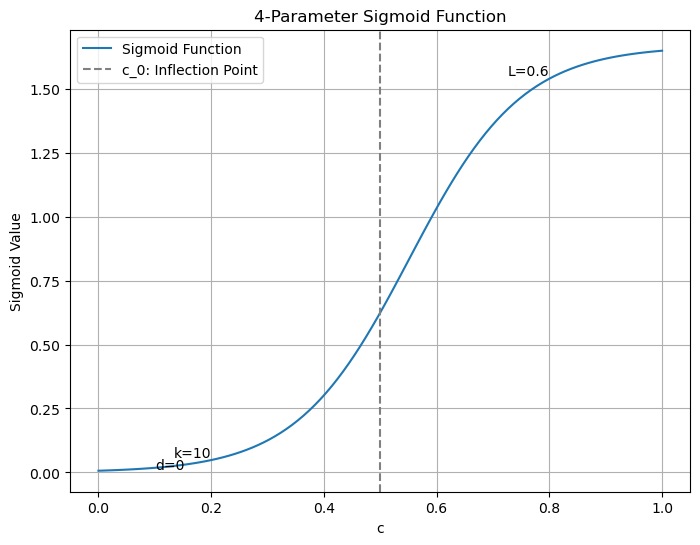

In [3]:
c = np.linspace(0, 1, 100)

# Example parameters for illustration
L_example = 0.6
k_example = 10
c_0_example = 0.5
d_example = 0

# Compute the sigmoid values
sigmoid_values = sigmoid_4para(c, L_example, k_example, c_0_example, d_example)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(c, sigmoid_values, label='Sigmoid Function')

# Illustrating c_0 - the inflection point
plt.axvline(x=c_0_example, color='gray', linestyle='--', label='c_0: Inflection Point')

# Annotations for other parameters
plt.text(0.8, sigmoid_4para(0.8, L_example, k_example, c_0_example, d_example), f'L={L_example}', verticalalignment='bottom', horizontalalignment='right')
plt.text(0.2, sigmoid_4para(0.2, L_example, k_example, c_0_example, d_example), f'k={k_example}', verticalalignment='bottom', horizontalalignment='right')
plt.text(0.1, d_example, f'd={d_example}', verticalalignment='bottom', horizontalalignment='left')

plt.xlabel('c')
plt.ylabel('Sigmoid Value')
plt.title('4-Parameter Sigmoid Function')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
GDSC_df = pd.read_excel('./GDSC2_dataset/GDSC2_fitted_dose_response_27Oct23.xlsx')

In [5]:
df = pd.read_csv('./GDSC2_curve_data/GDSC2_7_conc_Dec16.csv')

In [6]:
df = df[df.dilution_pattern == 'half-log']
x_cols = [f'x_{i}' for i in range(7)]
y_cols = [f'y_{i}' for i in range(7)]
for i, col in enumerate(x_cols):
    df[col] = (i + 1)/ 7

In [7]:
y_cols = [f'y_{i}' for i in range(7)]
result_df= df[['CL_drug_conc'] + y_cols]
result_df['min_y'] = result_df[y_cols].min(axis=1)
result_df['max_y'] = result_df[y_cols].max(axis=1)
sub_df = result_df[(result_df.max_y > 0.5) & (result_df.min_y < 0.5)]
sub_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_3760868/996649852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['min_y'] = result_df[y_cols].min(axis=1)
/tmp/ipykernel_3760868/996649852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['max_y'] = result_df[y_cols].max(axis=1)


In [8]:
df_full = pd.read_csv('./GDSC2_curve_data/Dec20_4_2_fitted.csv')

In [9]:
df_full['CL'] = df_full['CL_drug_conc'].apply(lambda x: x.split('_')[0])
df_full['drug'] = df_full['CL_drug_conc'].apply(lambda x: x.split('_')[1])
df_full['conc'] = df_full['CL_drug_conc'].apply(lambda x: x.split('_')[2])
df_full['IC50_4_para'] = df_full['IC50_4_para'].clip(lower=0, upper=1.5)
df_full['IC50_2_para'] = df_full['IC50_2_para'].clip(lower=0, upper=1.5)

In [10]:
x_values = [i/7 for i in range(1, 8)]
for i, x in enumerate(x_values):
    df_full[f'x_{i}'] = x
    
new_df = df_full.copy()

# Step 3: For each CL_drug_conc, keep the rows with minimum rmse_2_para and rmse_4_para
min_rmse_2_df = new_df.loc[new_df.groupby('CL_drug_conc')['rmse_2_para'].idxmin()]
min_rmse_4_df = new_df.loc[new_df.groupby('CL_drug_conc')['rmse_4_para'].idxmin()]
for i in range(7):
    min_rmse_2_df[f'pred_2_{i}'] = min_rmse_2_df.apply(
        lambda row: sigmoid_2para(x_values[i], row['2_para_0'], row['2_para_1']), axis=1
    )
    min_rmse_2_df[f'true_2_{i}'] = min_rmse_2_df[f'y_{i}']
for i in range(7):
    min_rmse_4_df[f'pred_4_{i}'] = min_rmse_4_df.apply(
        lambda row: sigmoid_4para(x_values[i], row['4_para_0'], row['4_para_1'], row['4_para_2'], row['4_para_3']), axis=1
    )
    min_rmse_4_df[f'true_4_{i}'] = min_rmse_4_df[f'y_{i}']
min_rmse_2_df.drop(columns=['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6'], inplace=True)
min_rmse_4_df.drop(columns=['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6'], inplace=True)

/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))
/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))
/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))
/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))
/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))
/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))
/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))
/tmp/ipykernel_3760868/3963090468.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (L + np.exp(-k * (c

In [11]:
para_4_related_cols = ['CL_drug_conc', '4_para_0', '4_para_1', '4_para_2', '4_para_3', 'rmse_4_para', 'IC50_4_para'] + [f'pred_4_{i}' for i in range(7)] + [f'true_4_{i}' for i in range(7)]
para_2_related_cols = ['CL_drug_conc', '2_para_0', '2_para_1', 'rmse_2_para', 'IC50_2_para'] + [f'pred_2_{i}' for i in range(7)] + [f'true_2_{i}' for i in range(7)] + [f'x_{i}' for i in range(7)] + ['IC50_x']
combined_df = pd.merge(min_rmse_2_df[para_2_related_cols], min_rmse_4_df[para_4_related_cols], on='CL_drug_conc')

In [12]:

combined_df['CL'] = combined_df['CL_drug_conc'].apply(lambda x: x.split('_')[0])
combined_df['drug'] = combined_df['CL_drug_conc'].apply(lambda x: x.split('_')[1])
combined_df['conc'] = combined_df['CL_drug_conc'].apply(lambda x: x.split('_')[2])

In [13]:
select_rows = lambda df, CL, drug: df[(df['CL'] == CL) & (df['drug'] == drug)]
cell_meta = pd.read_csv('./GDSC2_dataset/meta_data/cell_meta.csv')
drug_meta = pd.read_csv('./GDSC2_dataset/meta_data/drug_meta.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_values = df[x_cols].values[0]
x_train = torch.tensor(df[x_cols].values[0], dtype=torch.float32).unsqueeze(1)
y_df = torch.tensor(df[y_cols].values, dtype=torch.float32)
x_dense = np.linspace(-0.1, 1.1, 100000)
x_dense_tensor = torch.tensor(x_dense, dtype=torch.float32).unsqueeze(1)
x_train_gpu = x_train.to(device)
y_df_gpu = y_df.to(device)
x_dense_tensor_gpu = x_dense_tensor.to(device)
# df_torch = df[['CL_drug_conc', 'CL', 'drug', 'conc'] + y_cols]
def plot_all_observation_curves(df, CL, drug, show_2_para = True, show_4_para = True, show_nn_group = True, plot_all_obs = True, plot_all_curves = True, show_IC50 = 'Best'):
    """
    Plot all observation curves for a given cell line and drug.

    Parameters:
    df : DataFrame
        The DataFrame containing the dose-response data.
    CL : str
        The cell line identifier.
    drug : str
        The drug identifier.
    show_2_para : bool, optional
        If True, display the 2-parameter sigmoid curves. Default is True.
    show_4_para : bool, optional
        If True, display the 4-parameter sigmoid curves. Default is True.
    show_nn_group : bool, optional
        If True, display the neural network group prediction curves. Default is True.
    plot_all_obs : bool, optional
        If True, plot all observations. Default is True.
    plot_all_curves : bool, optional
        If True, plot all individual fitted curves. Default is True.
    show_IC50 : str, optional
        Specifies which IC50 value to display. Options are 'Best', 'Mean'. Default is 'Best'.

    Description:
    This function plots the dose-response curves for a specified cell line and drug. It allows for the visualization
    of both 2-parameter and 4-parameter sigmoid curves, as well as neural network group predictions. The function
    can show individual observations, fitted curves, and IC50 values based on different criteria.
    """
    sub_row = select_rows(df = df, CL = CL, drug = drug)
    num_obs = len(sub_row)
    best_idx_2_para = sub_row['rmse_2_para'].idxmin()
    best_idx_4_para = sub_row['rmse_4_para'].idxmin()
    y_values = sub_row[y_cols].values
    GDSC_IC50 = sub_row['IC50_x'].unique()[0]
    sigmoid_4_IC50 = sub_row.loc[best_idx_4_para,'IC50_4_para']
    sigmoid_2_IC50 = sub_row.loc[best_idx_2_para,'IC50_2_para']
    sigmoid_2_rmse = sub_row.loc[best_idx_2_para,'rmse_2_para']
    sigmoid_4_rmse = sub_row.loc[best_idx_4_para,'rmse_4_para']
    mean_2_IC50 = calculate_mean_excluding_values(sub_row, 'IC50_2_para', [0, 1.5])
    mean_4_IC50 = calculate_mean_excluding_values(sub_row, 'IC50_4_para', [0, 1.5])
    # IC_50_NN = sub_row['IC_50_NN']


    pair = sub_row.CL_drug_conc.unique()[0]

    if show_nn_group:
        pair = sub_row.CL_drug_conc.unique()[0]
        rmse_nn_group = sub_row['rmse_nn_group'].values[0]
        IC_50_NN_group = sub_row['IC_50_NN_group'].values[0]
        model_nn_para = torch.load(f'./fitting_curve/weight_group/NN_curve_{pair}.pth')
        model = Net()
        model.load_state_dict(model_nn_para)
        y_dense_tensor = model(x_dense_tensor)
        pred_nn_group = model(x_train)
        # rmse_nn_group = nn.MSELoss()(pred_nn_group.squeeze(dim = 1), torch.tensor(y_values.astype(np.float32))).item()
    sigmoid_4_model_cols = ['4_para_0', '4_para_1', '4_para_2', '4_para_3']
    sigmoid_2_model_cols = ['2_para_0', '2_para_1']
    sigmoid_4_dict = {'rmse': sigmoid_4_rmse, 'model': sub_row.loc[best_idx_4_para, sigmoid_4_model_cols]}
    sigmoid_2_dict = {'rmse': sigmoid_2_rmse, 'model': sub_row.loc[best_idx_2_para, sigmoid_2_model_cols]}
    CL,drug_name,maxc = sub_row.CL_drug_conc.unique()[0].split('_')
    cell_name = cell_meta[cell_meta.COSMIC_ID == int(CL)].CELL_LINE_NAME.unique()[0]
    if int(drug_name) in drug_meta.DRUG_ID.unique():
        drug_identifier = drug_meta[drug_meta.DRUG_ID == int(drug_name)].DRUG_NAME.unique()[0]
    else:
        drug_identifier = drug_name
    a, b = sigmoid_2_dict['model']
    # x_high = max(4*b + a, 1.1)
    # x_high = min(x_high, 1.5)
    # x_low = min(-4*b + a, 0)
    # x_low = max(x_low, -1.)
    y_low = y_values.min() - 0.2
    y_low = max(y_low, -0.1)
    y_high = y_values.max() + 0.2
    y_high = min(y_high, 1.1)
    x_high = 1.1
    x_low = -0.1
    ## use np linspace to generate 1000 points between x_low and x_high      
    x_dense = np.linspace(x_low, x_high, 1000)
    rmse_sigmoid_2_predictions = sigmoid_2_dict['rmse']
    predicted_sig_2para = sigmoid_2para(x_dense, a, b)
    pred_sig2_y = sigmoid_2para(x_values, a, b)
    pred_sig4_y = sigmoid_4para(x_values, *sigmoid_4_dict['model'])
    L_fit, k_fit, x0_fit, d_fit = sigmoid_4_dict['model']
    rmse_sigmoid_4_predictions = sigmoid_4_dict['rmse']
    predicted_sig_4para = sigmoid_4para(x_dense, L_fit, k_fit, x0_fit, d_fit)
    fig, ax = plt.subplots(dpi=200)
    ## Curves
    if show_2_para:
        plt.plot(x_dense, predicted_sig_2para, label=f'Fitted Sigmoid 2-Parameter\nRMSE: {rmse_sigmoid_2_predictions:.3f}', color = '#3C5488FF')
    if show_4_para:
        plt.plot(x_dense, predicted_sig_4para, label=f'Fitted Sigmoid 4-Parameter\nRMSE: {rmse_sigmoid_4_predictions:.3f}', color='#F39B7FFF')
    if show_nn_group:
        plt.plot(x_dense_tensor, y_dense_tensor.detach().numpy(), label=f'Fitted Neural network group\nRMSE: {rmse_nn_group:.3f}', color = '#00A087FF')
    ## Scatter
    if plot_all_obs:
        for i, (x_col, y_final_cols) in enumerate(zip(x_cols, y_cols)):
            # If only one unique maxc value, use a single color (e.g., 'blue')
            x_value_tmp = x_values[i]
            ## Repeat x_value_tmp for len(sub_row) times
            x_value_tmp = np.repeat(x_value_tmp, len(sub_row))
            if i == 0:
                scatter = plt.scatter(x_value_tmp, sub_row[y_final_cols], 
                                    color='black', marker='o', facecolors='none', edgecolors='black', label = f'Observation: {num_obs} observations', alpha=0.5)
            else:
                scatter = plt.scatter(x_value_tmp, sub_row[y_final_cols], 
                                    color='black', marker='o', facecolors='none', edgecolors='black', alpha=0.5)
        
        if plot_all_curves:
            for row in sub_row.iterrows():
                a_,b_ = row[1][sigmoid_2_model_cols]
                L_fit_, k_fit_, x0_fit_, d_fit_ = row[1][sigmoid_4_model_cols]
                predicted_sig_2para_ = sigmoid_2para(x_dense, a_, b_)
                predicted_sig_4para_ = sigmoid_4para(x_dense, L_fit_, k_fit_, x0_fit_, d_fit_)
                plt.plot(x_dense, predicted_sig_2para_, color = '#3C5488FF', alpha = 0.2)
                plt.plot(x_dense, predicted_sig_4para_, color = '#F39B7FFF', alpha = 0.2)
    else:
        plt.scatter(x_values, sub_row.loc[best_idx_2_para, y_cols], color='black', marker='o', facecolors='none', edgecolors='black', label = f'Observation: {num_obs} observations')
        plt.scatter(x_values, sub_row.loc[best_idx_4_para, y_cols], color='black', marker='o', facecolors='none', edgecolors='black')
    # plt.scatter(x_values, y_values, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Observation')
    if show_2_para:
        plt.scatter(x_values, pred_sig2_y, marker='^', color='#3C5488FF', label='2_para prediction')
    if show_4_para:
        plt.scatter(x_values, pred_sig4_y, marker='^', color='#F39B7FFF', label='4_para prediction') 
    if show_nn_group:
        plt.scatter(x_values, pred_nn_group.detach().numpy(), marker='^', color='#00A087FF', label='NN prediction with group')
    ## GDSC IC50    
    plt.scatter(GDSC_IC50, [0.5], color='red', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(GDSC_IC50, color='red', linestyle='dashed', linewidth= 1, label=f'GDSC IC50: {GDSC_IC50:.3f}')
    ## 2 para
    if show_2_para:
        if show_IC50 == 'Best':
            plt.scatter(sigmoid_2_IC50, [0.5], color='#3C5488FF', marker='s', s=40, alpha=0.6)  # 's' for square shape
            plt.axvline(sigmoid_2_IC50, color='#3C5488FF', linestyle='dashed', linewidth=1, label=f'2_para IC50: {sigmoid_2_IC50:.3f}')
        else:
            plt.scatter(mean_2_IC50, [0.5], color='#3C5488FF', marker='s', s=40, alpha=0.6)  # 's' for square shape
            plt.axvline(mean_2_IC50, color='#3C5488FF', linestyle='dashed', linewidth=1, label=f'Mean 2_para IC50: {mean_2_IC50:.3f}')
    ## 4 para
    if show_4_para:
        if show_IC50 == 'Best':
            plt.scatter(sigmoid_4_IC50, [0.5], color='#F39B7FFF', marker='s', s=40)  # 's' for square shape
            plt.axvline(sigmoid_4_IC50, color='#F39B7FFF', linestyle='dashed', linewidth = 1, label=f'4_para IC50: {sigmoid_4_IC50:.3f}')
        else:
            plt.scatter(mean_4_IC50, [0.5], color='#F39B7FFF', marker='s', s=40, alpha=0.6)  # 's' for square shape
            plt.axvline(mean_4_IC50, color='#F39B7FFF', linestyle='dashed', linewidth=1, label=f'Mean 4_para IC50: {mean_4_IC50:.3f}')
    ## NN for IC50      
    if show_nn_group:
        plt.scatter(IC_50_NN_group, [0.5], color='#3D9140', marker='s', s=40, alpha=0.6)
        plt.axvline(IC_50_NN_group, color='#3D9140', linestyle='dashed', linewidth=1, label=f'NN group IC50: {IC_50_NN_group:.3f}')
    plt.axhline(0.5, color='black', linestyle='-.', linewidth= 1, label = 'Response Level 50%')
    plt.xlabel('Normalized concentration', fontsize=12)
    plt.ylabel('Normalized response', fontsize=12)
    plt.ylim(y_low, 1.1)
    # drug_name = drug.split('_')[0]
    # maxc = drug.split('_')[1]
    plt.title(f'Dose-response curves for drug {drug_name} on cell line {CL} with max concentration {maxc} µM')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    annotation_x = x_low + (x_high - x_low) * 0.1 # Adjust horizontal position
    annotation_y = 0.8
    plt.annotate(f"Cell-line: {cell_name}\n\nDrug: {drug_identifier}\n\nMax dose = {maxc} uM",
                    (annotation_x, annotation_y), ha='left', va='center', fontsize= 11, xycoords='axes fraction')

    plt.grid(False)
    return fig, ax

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1051 on cell line 908134 with max concentration 10 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

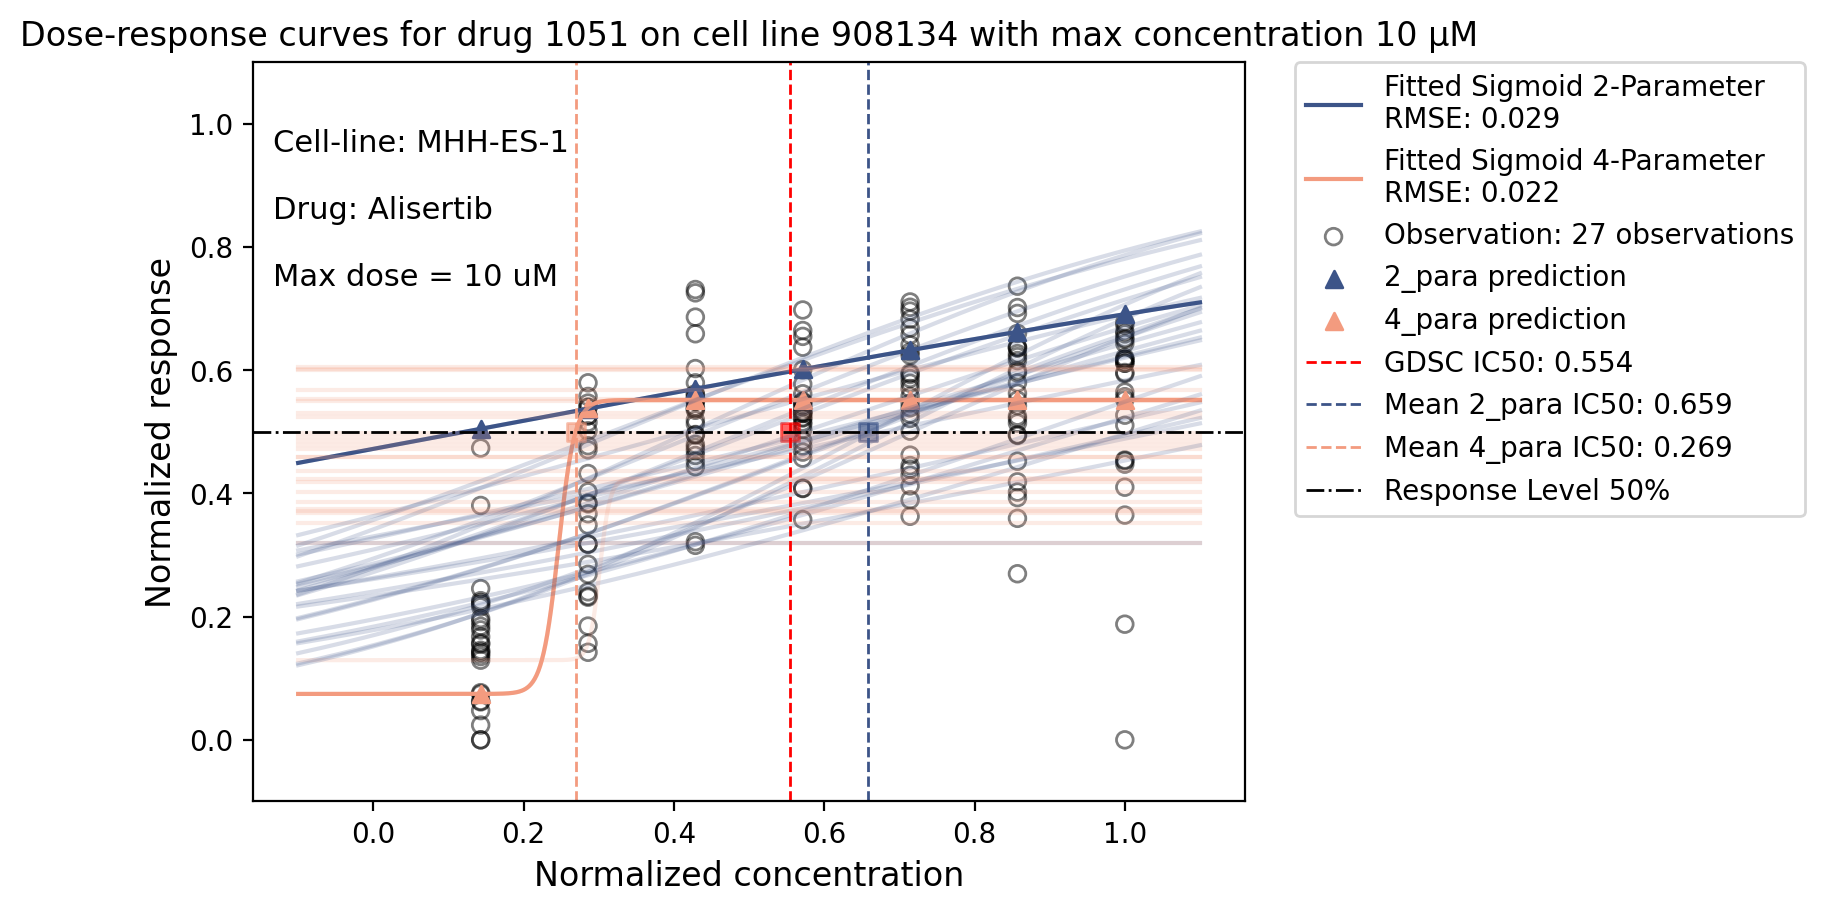

In [14]:
plot_all_observation_curves(df = df_full, CL = '908134', drug = '1051', plot_all_obs= True, show_nn_group = False, show_IC50 = 'Mean')

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 2106 on cell line 906793 with max concentration 10 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

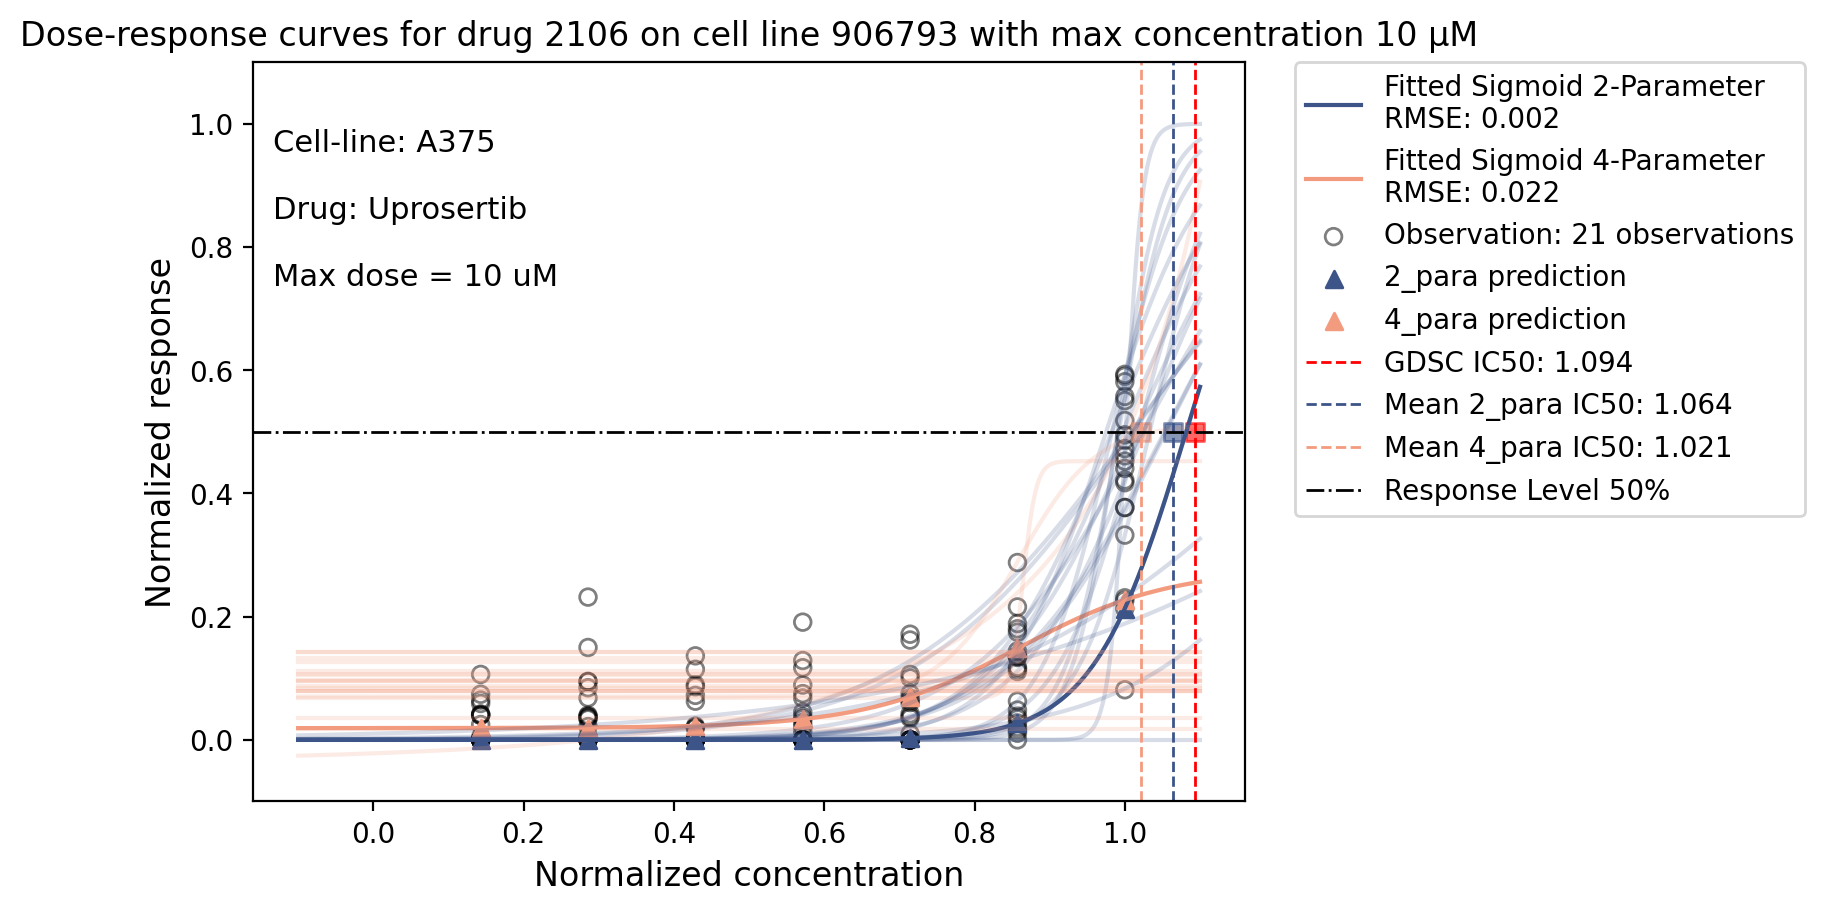

In [15]:
plot_all_observation_curves(df = df_full, CL = '906793', drug = '2106', plot_all_obs= True, show_nn_group = False, show_IC50 = 'mean')

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1578 on cell line 1331036 with max concentration 100 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

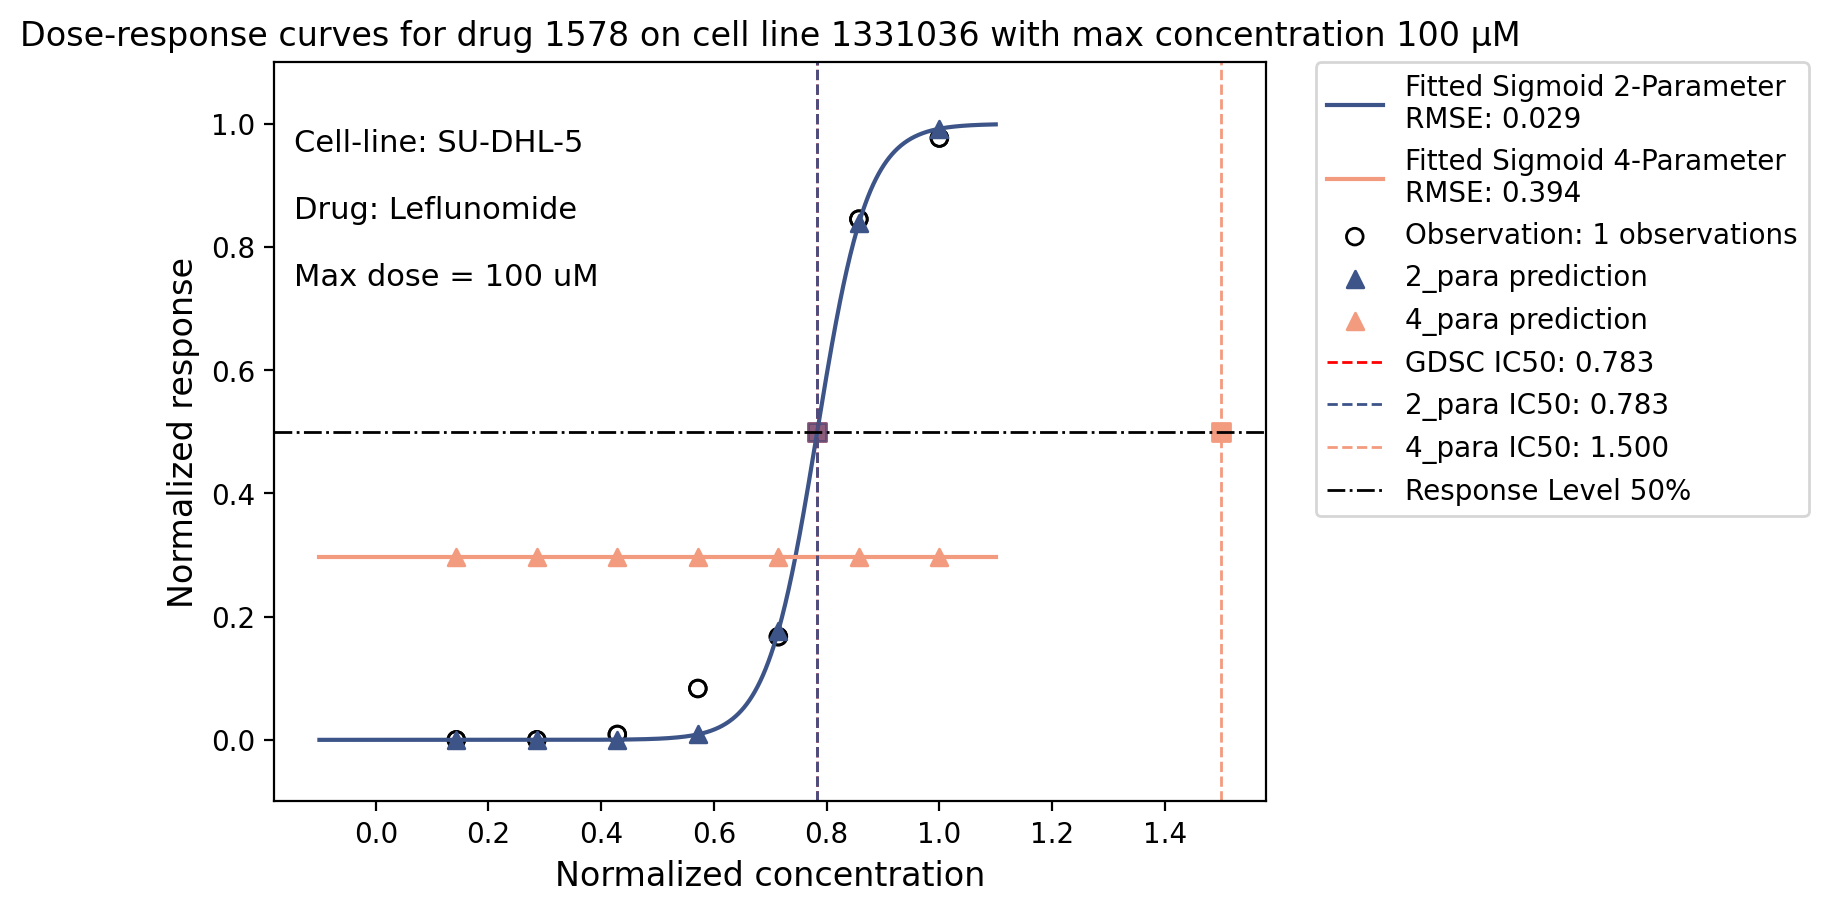

In [16]:
plot_all_observation_curves(df = df_full, CL = '1331036', drug = '1578', plot_all_obs= False, show_nn_group = False, show_IC50 = 'Best')

### Only drug 1578 tested on max conc 100

In [17]:
df_full[df_full.conc == '100'].drug.unique()

array(['1578'], dtype=object)

### Only drug '1131', '1375', '1804 tested on max conc 30, and 1073 on 32

In [18]:
df_full[df_full.conc == '30'].drug.unique()

array(['1131', '1375', '1804'], dtype=object)

In [19]:
df_full[df_full.conc == '32'].drug.unique()

array(['1073'], dtype=object)

### Drug '1239', '1629', '1813', '1814', '1835', '1073' tested on 20.

In [20]:
df_full[df_full.conc == '20'].drug.unique()

array(['1239', '1629', '1813', '1814', '1835', '1073'], dtype=object)

### Only drug 1083 tested on 8, while 111 drugs have been tested on 10

In [21]:
df_full[df_full.conc == '8'].drug.unique()

array(['1083'], dtype=object)

In [22]:
df_full[df_full.conc == '8'].drug.unique()

array(['1083'], dtype=object)

In [23]:
df_full[df_full.conc == '0.01'].drug.unique()

array(['1080'], dtype=object)

In [24]:
unique_drug_counts = df_full.groupby('conc')['drug'].nunique().sort_values()

print(unique_drug_counts)

conc
0.01        1
0.0125      1
0.8         1
100         1
2.5         1
32          1
8           1
0.02        2
30          3
0.25        3
4           4
3           4
20          6
0.1         6
5           6
2          10
1          18
10        111
Name: drug, dtype: int64


In [25]:
true_y_cols = [f'true_4_{i}' for i in range(7)] + [f'true_2_{i}' for i in range(7)] 
combined_df['min_y'] = combined_df[true_y_cols].min(axis=1)
combined_df['max_y'] = combined_df[true_y_cols].max(axis=1)
combined_df['diff'] = combined_df['max_y'] - combined_df['min_y']
combined_df['min_2_y'] = combined_df[[f'true_2_{i}' for i in range(7)]].min(axis=1)
combined_df['max_2_y'] = combined_df[[f'true_2_{i}' for i in range(7)]].max(axis=1)
combined_df['diff_2'] = combined_df['max_2_y'] - combined_df['min_2_y']
combined_df['min_4_y'] = combined_df[[f'true_4_{i}' for i in range(7)]].min(axis=1)
combined_df['max_4_y'] = combined_df[[f'true_4_{i}' for i in range(7)]].max(axis=1)
combined_df['diff_4'] = combined_df['max_4_y'] - combined_df['min_4_y']

In [26]:
combined_df.sort_values(by='diff_2', ascending=False).head(5000)

,CL_drug_conc,2_para_0,2_para_1,rmse_2_para,IC50_2_para,pred_2_0,pred_2_1,pred_2_2,pred_2_3,pred_2_4,...,conc,min_y,max_y,diff,min_2_y,max_2_y,diff_2,min_4_y,max_4_y,diff_4
58093,909743_1248_0.1,0.474036,0.042630,0.022892,0.474036,4.225851e-04,1.191946e-02,0.256072,0.907595,0.996445,...,0.1,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
44981,907281_1011_10,0.477577,0.037115,0.019837,0.477577,1.211519e-04,5.656070e-03,0.210758,0.926124,0.998304,...,10,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
44831,907277_2040_10,0.606275,0.042484,0.059171,0.606275,1.830917e-05,5.282182e-04,0.015026,0.305713,0.927060,...,10,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
45010,907281_1179_10,0.583847,0.034339,0.007482,0.583847,2.646098e-06,1.695553e-04,0.010751,0.410562,0.978089,...,10,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
39880,906856_1068_10,0.531488,0.043072,0.028970,0.531488,1.206090e-04,3.314512e-03,0.083984,0.716527,0.985853,...,10,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.846282,0.846282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61300,909975_1617_10,0.828999,0.225016,0.159169,0.828999,4.524772e-02,8.207931e-02,0.144359,0.241463,0.375240,...,10,0.078756,0.952995,0.874240,0.078756,0.952995,0.874240,0.078756,0.952995,0.874240
68038,924110_2040_10,0.861485,0.130735,0.094124,0.861485,4.083056e-03,1.207945e-02,0.035183,0.098088,0.244913,...,10,0.000000,0.874182,0.874182,0.000000,0.874182,0.874182,0.000000,0.874182,0.874182
15775,1503371_1617_10,0.924255,0.040529,0.082943,0.924255,4.234219e-09,1.437432e-07,0.000005,0.000166,0.005592,...,10,0.000000,0.874143,0.874143,0.000000,0.874143,0.874143,0.000000,0.874143,0.874143
25890,749712_1941_10,0.399256,0.079249,0.092592,0.399256,3.785612e-02,1.926740e-01,0.591439,0.897758,0.981571,...,10,0.066987,0.941127,0.874140,0.066987,0.941127,0.874140,0.066987,0.941127,0.874140


(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1911 on cell line 909744 with max concentration 0.8 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

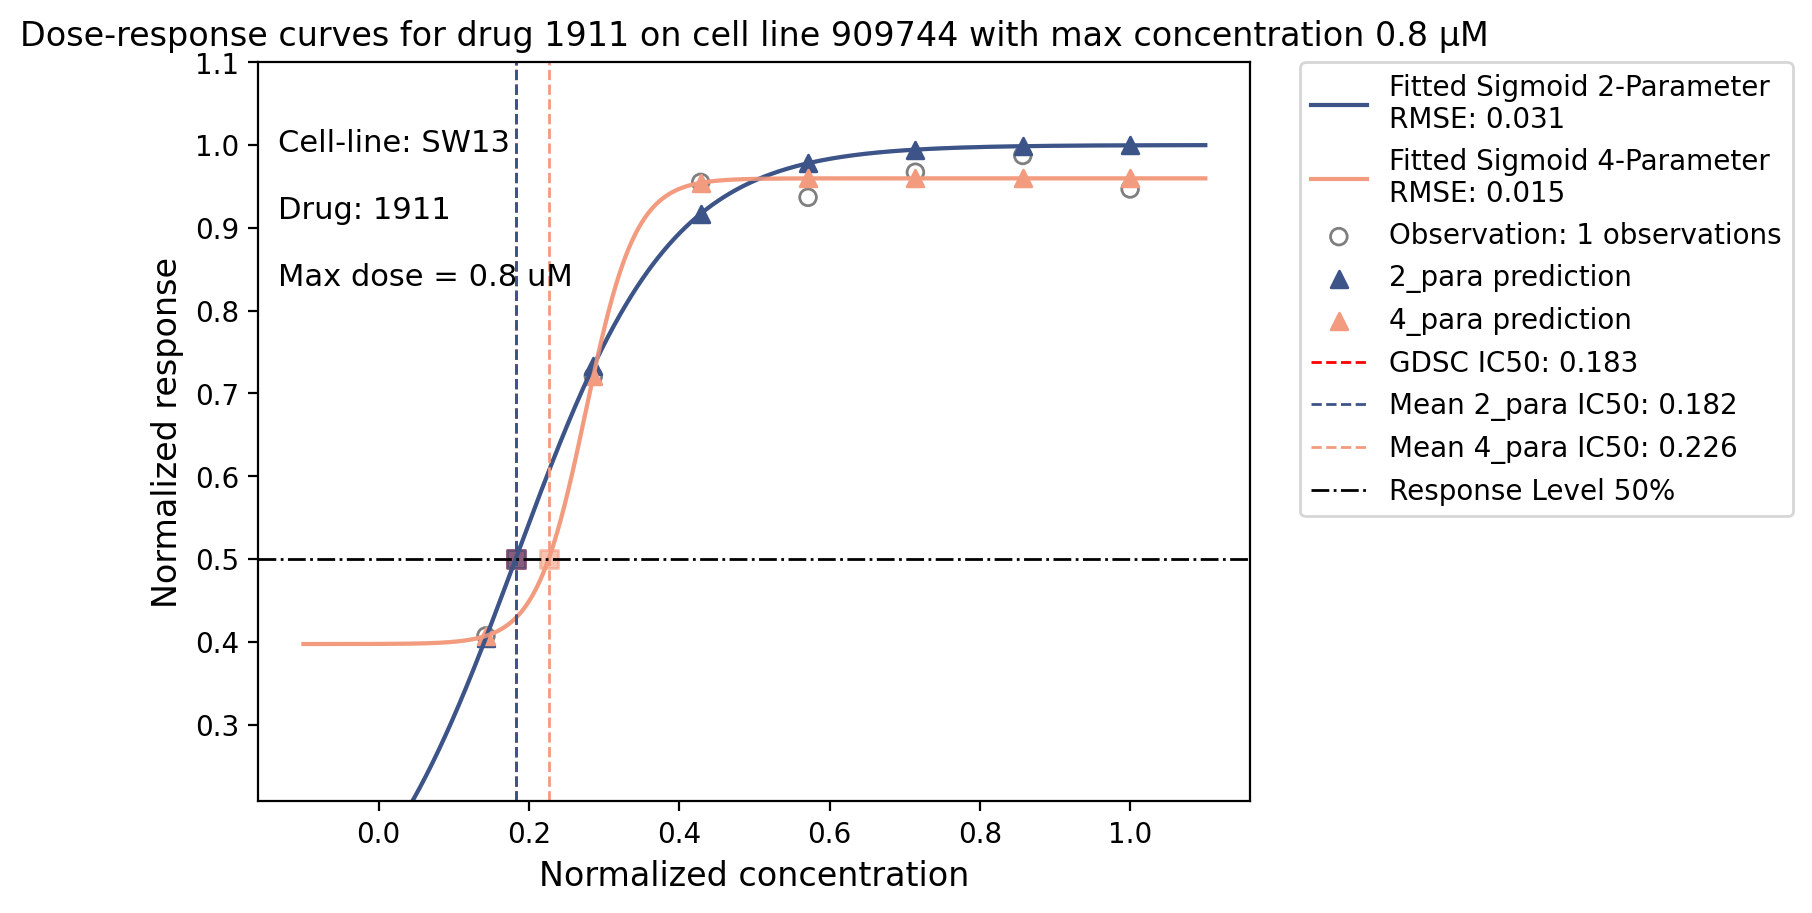

In [27]:
plot_all_observation_curves(df = df_full, CL = '909744', drug = '1911', plot_all_obs= True, show_nn_group = False, show_IC50 = 'max')

In [28]:
df_full.groupby('drug')['conc'].nunique().loc[lambda x: x > 1]

drug
1013    2
1022    2
1032    2
1049    2
1051    2
1054    2
1058    2
1060    2
1073    2
1080    2
1083    2
1084    2
1088    2
1168    2
1190    2
1248    2
1511    2
1549    2
1559    2
1560    2
1786    2
Name: conc, dtype: int64

In [29]:
df_full.groupby('drug').filter(lambda x: x['conc'].nunique() > 1)[['drug', 'conc']].drop_duplicates().sort_values('drug')

,drug,conc
12,1013,2
19158,1013,10
14,1022,10
14533,1022,2
15,1032,10
7758,1032,4
63221,1049,2
208,1049,10
21,1051,10
65200,1051,2


In [30]:
df_full['y_diff'] = df_full['max_y'] - df_full['min_y']
df_full.y_diff.describe()

count    142565.000000
mean          0.387611
std           0.271284
min           0.000000
25%           0.161680
50%           0.306750
75%           0.598049
max           1.000000
Name: y_diff, dtype: float64

In [31]:
df_full.min_y.value_counts()

min_y
0.000000    104023
0.001840         6
0.034754         5
0.019673         5
0.001077         5
             ...  
0.038846         1
0.020117         1
0.010359         1
0.030443         1
0.117667         1
Name: count, Length: 34678, dtype: int64

In [32]:
df_full['y_6'].value_counts()

y_6
0.000000    17052
1.000000       81
0.251887        6
0.018225        4
0.936304        4
            ...  
0.899894        1
0.177824        1
0.194046        1
0.262913        1
0.164995        1
Name: count, Length: 118527, dtype: int64

array([[<Axes: title={'center': 'min_y'}>]], dtype=object)

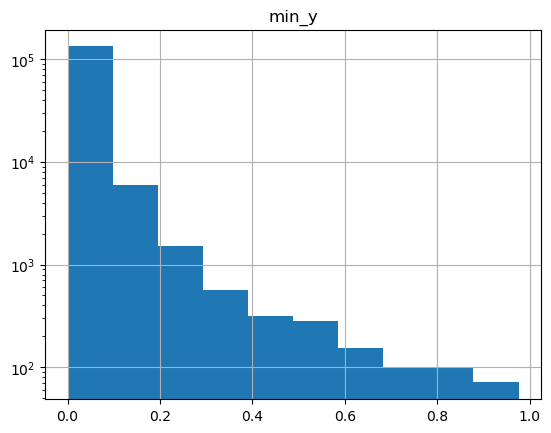

In [33]:
df_full.hist(column='min_y', bins=10, log=True)

array([[<Axes: title={'center': 'y_diff'}>]], dtype=object)

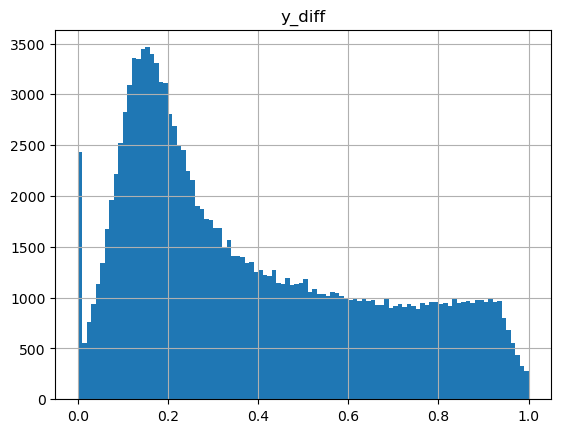

In [34]:
df_full.hist(column='y_diff', bins=100)

In [35]:
unique_CL_counts = df_full.groupby('conc')['CL'].nunique().sort_values()

print(unique_CL_counts)

conc
8          20
4          37
0.01      334
32        470
100       476
0.0125    500
3         514
0.8       516
0.02      540
0.25      548
30        558
0.1       561
20        564
2.5       565
5         567
2         569
1         570
10        570
Name: CL, dtype: int64


In [36]:
df_full.groupby('conc')['CL_drug_conc'].nunique().sort_values()

conc
8            20
4            41
0.01        334
32          470
100         476
0.0125      500
0.8         516
0.25        550
2.5         565
0.02        965
30         1418
0.1        1783
5          1871
3          1920
20         2376
2          2927
1          7260
10        47134
Name: CL_drug_conc, dtype: int64

In [37]:
df_full[['CL_drug_conc'] + y_cols]

,CL_drug_conc,y_0,y_1,y_2,y_3,y_4,y_5,y_6
0,683667_1003_0.1,0.000000,0.024727,0.000000,0.162665,0.216316,0.262269,0.338897
1,683667_1003_0.1,0.000000,0.076143,0.000000,0.083908,0.060611,0.332530,0.456860
2,683667_1003_0.1,0.144109,0.121738,0.059118,0.112799,0.126184,0.188805,0.358787
3,683667_1003_0.1,0.000000,0.210885,0.000000,0.021474,0.267714,0.158813,0.352932
4,683667_1003_0.1,0.000000,0.000000,0.000000,0.000000,0.066947,0.000000,0.199833
...,...,...,...,...,...,...,...,...
142560,1674021_2106_10,0.013285,0.131295,0.141819,0.354885,0.240844,0.369379,0.377787
142561,1674021_2107_10,0.101786,0.070188,0.127065,0.025924,0.000000,0.000000,0.000000
142562,1674021_2109_10,0.167098,0.154458,0.057522,0.091236,0.202926,0.158663,0.636919
142563,1674021_2110_10,0.023809,0.072277,0.000000,0.072277,0.000000,0.087031,0.164982


In [38]:
def last_occurrence_of_min(row):
    # Reverse the row and find the first (in reverse order) occurrence of the min value
    return row[::-1].idxmin().split('_')[1]

def first_occurrence_of_max(row):
    # Find the first occurrence of the max value
    return row.idxmax().split('_')[1]

# Applying the functions to each row for the y columns
df_full['last_min_y_index'] = df_full[y_cols].apply(last_occurrence_of_min, axis=1)
df_full['first_max_y_index'] = df_full[y_cols].apply(first_occurrence_of_max, axis=1)


In [39]:
df_full[(df_full.last_min_y_index > df_full.first_max_y_index) & (df_full.y_diff > 0.2)].sort_values('max_y')

,CL_drug_conc,y_0,y_1,y_2,y_3,y_4,y_5,y_6,min_y,max_y,...,x_0,x_1,x_2,x_3,x_4,x_5,x_6,y_diff,last_min_y_index,first_max_y_index
34601,905949_1917_10,0.000000,0.000000,0.066864,0.047859,0.166720,0.200005,0.000000,0.000000,0.200005,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.200005,6,5
121227,1240174_1854_10,0.137681,0.006043,0.103057,0.000000,0.200037,0.000000,0.103057,0.000000,0.200037,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.200037,5,4
93307,909755_1625_10,0.200061,0.010478,0.091715,0.000000,0.159420,0.019499,0.000000,0.000000,0.200061,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.200061,6,0
62361,907056_1908_10,0.200073,0.000000,0.000000,0.100678,0.000000,0.000000,0.113936,0.000000,0.200073,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.200073,5,0
128717,1295740_1622_10,0.059220,0.200112,0.076821,0.000000,0.037197,0.028397,0.142888,0.000000,0.200112,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.200112,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22943,753608_1911_0.8,0.242994,0.446669,0.519467,0.799903,0.955823,0.876298,0.083844,0.083844,0.955823,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.871978,6,4
53692,906830_1372_1,0.045094,0.460903,0.771630,0.915589,0.956689,0.901889,0.000000,0.000000,0.956689,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.956689,6,4
58219,906844_1911_0.8,0.597391,0.886453,0.974285,0.972804,0.904817,0.630046,0.504889,0.504889,0.974285,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.469396,6,2
10638,724825_1561_10,0.294382,0.569375,0.770404,0.922879,0.980644,0.920582,0.097923,0.097923,0.980644,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.882721,6,4


In [40]:
df_full[(df_full.last_min_y_index < df_full.first_max_y_index) & (df_full.min_y > 0.4)].sort_values('y_diff')

,CL_drug_conc,y_0,y_1,y_2,y_3,y_4,y_5,y_6,min_y,max_y,...,x_0,x_1,x_2,x_3,x_4,x_5,x_6,y_diff,last_min_y_index,first_max_y_index
135476,1327771_1079_2,0.975840,0.988339,0.976363,0.985828,0.990822,1.000000,1.000000,0.975840,1.000000,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.024160,0,5
72440,908126_1079_2,0.980794,0.975280,0.981904,0.991847,1.000000,1.000000,0.992945,0.975280,1.000000,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.024720,1,4
128978,1295741_1941_10,0.963992,0.944913,0.963992,0.953590,0.950105,0.974394,0.957058,0.944913,0.974394,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.029481,1,5
16892,753572_1941_10,0.949109,0.973026,0.982370,0.970036,0.977518,0.976015,0.953585,0.949109,0.982370,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.033262,0,2
135488,1327771_1190_10,0.963108,0.998694,0.964967,0.972469,0.985593,0.994954,0.964967,0.963108,0.998694,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.035586,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34839,905949_1941_10,0.401349,0.952016,0.976121,0.966363,0.976121,0.980010,0.952741,0.401349,0.980010,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.578661,0,5
91646,909744_1911_0.8,0.407210,0.720936,0.954951,0.936841,0.967166,0.987429,0.946938,0.407210,0.987429,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.580219,0,5
56961,906834_1911_0.8,0.402954,0.853296,0.944381,0.983780,0.924151,0.957461,0.903922,0.402954,0.983780,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.580826,0,3
99776,909785_1911_0.8,0.410215,0.727469,0.891270,0.927151,0.977088,0.987469,0.992691,0.410215,0.992691,...,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0,0.582477,0,6


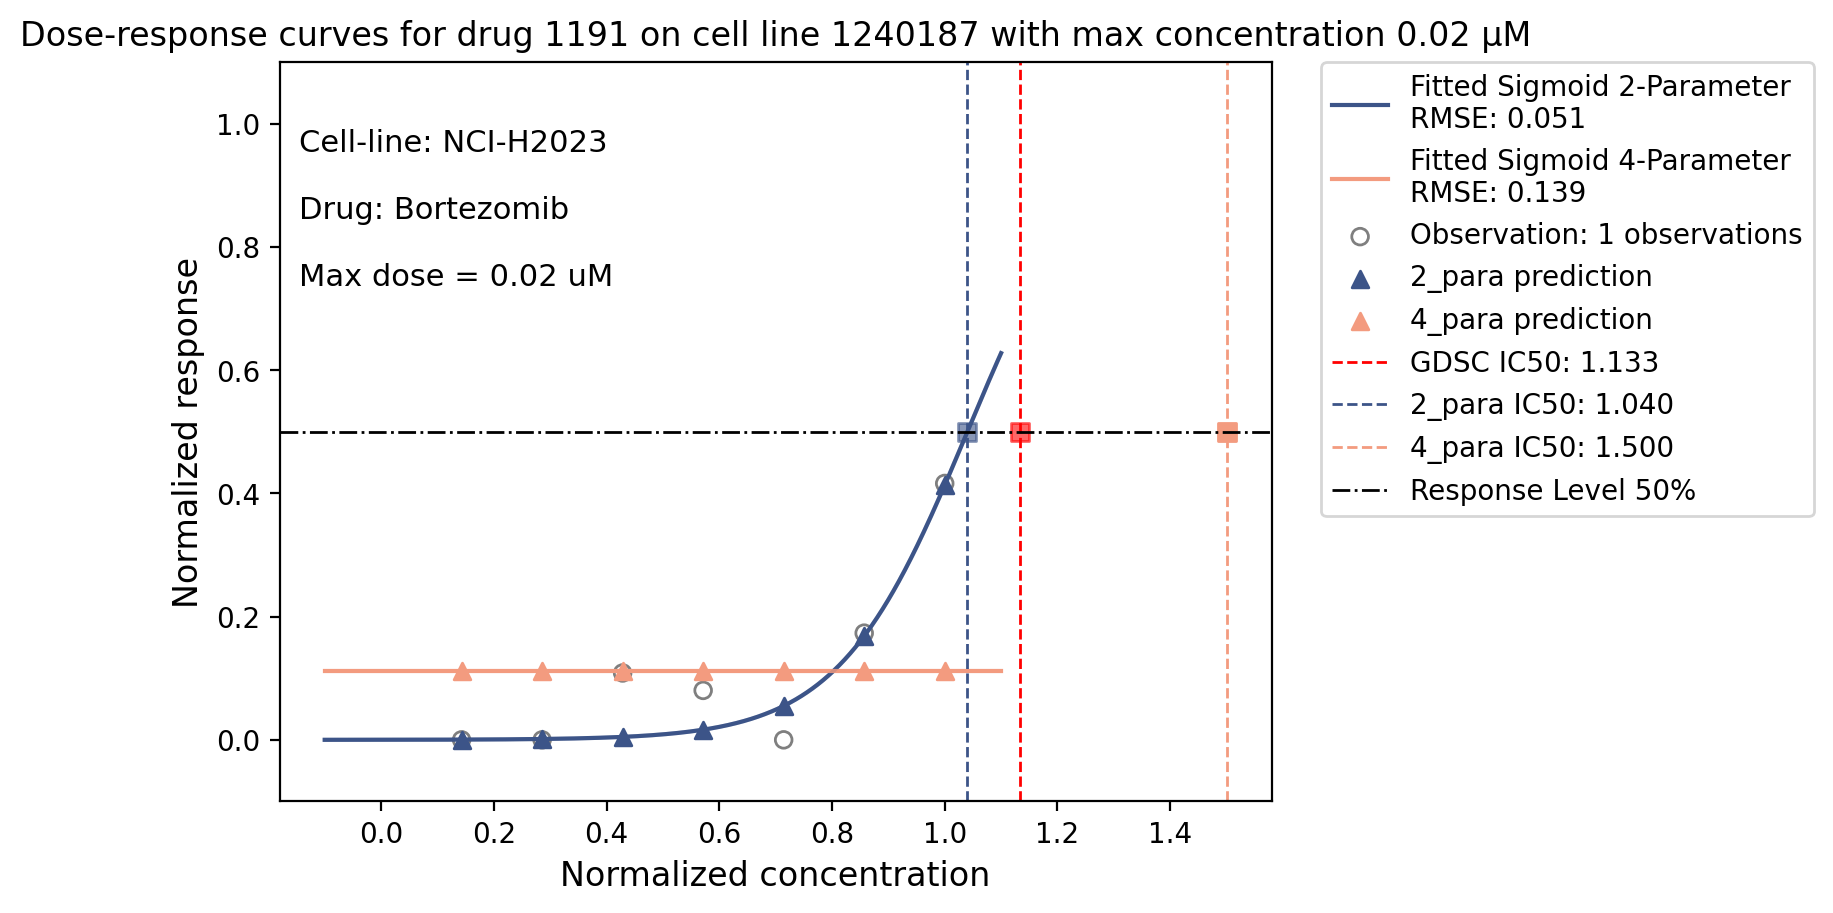

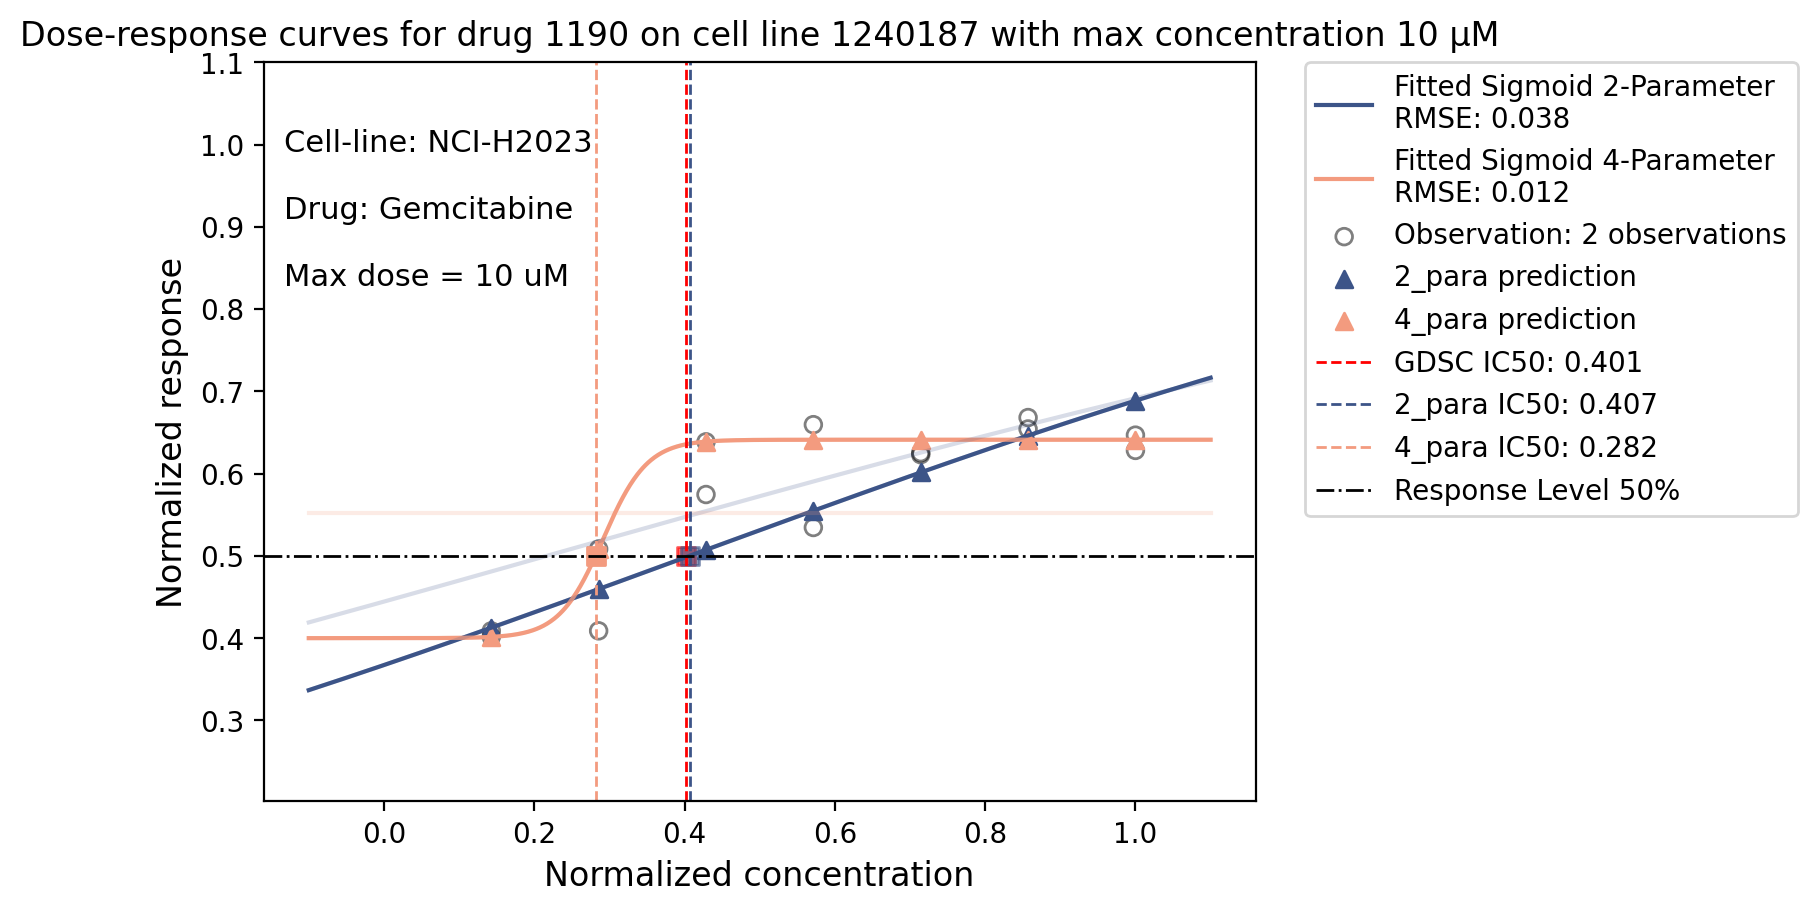

In [41]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot the first observation curve in the first subplot
plot_all_observation_curves(df=df_full, CL='1240187', drug='1191', plot_all_obs=True, show_nn_group=False, show_IC50='Best')

# Plot the second observation curve in the second subplot
plot_all_observation_curves(df=df_full, CL='1240187', drug='1190', plot_all_obs=True, show_nn_group=False, show_IC50='Best')

# # Adjust layout
# plt.tight_layout()
plt.show()

In [42]:
df_full[(df_full.last_min_y_index < df_full.first_max_y_index)].sort_values('rmse_2_para', ascending=False)[['CL_drug_conc', 'rmse_2_para']]

,CL_drug_conc,rmse_2_para
20666,753608_1191_0.02,3.602962e-01
53575,906830_1372_1,3.534456e-01
107714,910930_1003_0.1,3.513775e-01
20667,753608_1191_0.02,3.479621e-01
78258,908147_1003_0.1,3.453774e-01
...,...,...
132477,1298359_1085_10,5.252553e-13
52965,906830_1085_10,5.173493e-13
70168,907323_2109_10,5.144805e-13
61075,907042_1080_0.01,2.360901e-13


### Check pairs, where the x reaches smallest response, is larger than the max response

In [43]:
df_full[(df_full.last_min_y_index > df_full.first_max_y_index) & (df_full.y_diff > 0.2)].sort_values('y_diff', ascending=False)[['CL_drug_conc', 'y_diff']].head(50)

,CL_drug_conc,y_diff
53692,906830_1372_1,0.956689
44489,906793_1058_10,0.911795
129516,1297449_1510_10,0.904042
135780,1330931_1003_0.1,0.895632
10638,724825_1561_10,0.882721
22943,753608_1911_0.8,0.871978
57848,906842_1510_10,0.868291
47938,906793_2110_10,0.855216
23617,753608_1941_10,0.844976
52726,906830_1060_2.5,0.843455


## '906844', '1911' is a special inverse U case.

In [44]:
CL = '906844'
drug = '1911'


In [45]:
def plot_inverse_sigmoid(df_full, CL, drug):
    subrow = select_rows(df_full, CL, drug).sort_values('rmse_4_para').iloc[0]
    start = int(subrow.last_min_y_index)
    end = int(subrow.first_max_y_index) + 1
    # x_filter = subrow[x_cols].values[start:end]
    # y_filter = subrow[y_cols].values[start:end]
    x_filter = subrow[x_cols].values[end - 1:start + 1]
    y_filter = subrow[y_cols].values[end -1 :start + 1]
    x_opt = subrow[x_cols].values[0:end]
    y_opt = subrow[y_cols].values[0:end]
    x = subrow[x_cols].values
    y = subrow[y_cols].values
    popt_2para, _ = curve_fit(sigmoid_2para, x, y, maxfev=10000)
    popt_2para_filter, _ = curve_fit(sigmoid_2para, x_filter, y_filter, maxfev=10000)
    popt_2para_opt,_ = curve_fit(sigmoid_2para, x_opt, y_opt, maxfev=10000)
    popt_4para, _ = curve_fit(sigmoid_4para, x, y, maxfev=10000)
    popt_4para_filter, _ = curve_fit(sigmoid_4para, x_filter, y_filter, maxfev=10000)
    # popt_4para_opt,_ = curve_fit(sigmoid_4para, x_opt, y_opt, maxfev=10000)
    x_dense = np.linspace(-0.1, 1.1, 100000)
    y_dense_2para = sigmoid_2para(x_dense, *popt_2para)
    y_dense_2para_filter = sigmoid_2para(x_dense, *popt_2para_filter)
    y_dense_2para_opt = sigmoid_2para(x_dense, *popt_2para_opt)
    y_dense_4para = sigmoid_4para(x_dense, *popt_4para)
    y_dense_4para_filter = sigmoid_4para(x_dense, *popt_4para_filter)
    # y_dense_4para_opt = sigmoid_4para(x_dense, *popt_4para_opt)
    ## Plot
    # fig, ax = plt.subplots(dpi=200)
    plt.plot(x_dense, y_dense_2para, label=f'Fitted Sigmoid 2-Parameter', color = '#3C5488FF')
    plt.plot(x_dense, y_dense_2para_filter, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
    plt.plot(x_dense, y_dense_2para_opt, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
    plt.plot(x_dense, y_dense_4para, label=f'Fitted Sigmoid 4-Parameter', color='#F39B7FFF')
    plt.plot(x_dense, y_dense_4para_filter, color='orange')
    # plt.plot(x_dense, y_dense_4para_opt, color='orange')
    plt.scatter(x_filter, y_filter, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Filttered Observation')
    plt.scatter(subrow[x_cols].values, subrow[y_cols].values, color='red', marker='*', facecolors='none', edgecolors='black', label = 'Filttered Observation')

### Use two functions to estimate the Inverse-U shaped

/tmp/ipykernel_3760868/3963090468.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (L + np.exp(-k * (c - c_0))) + d
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


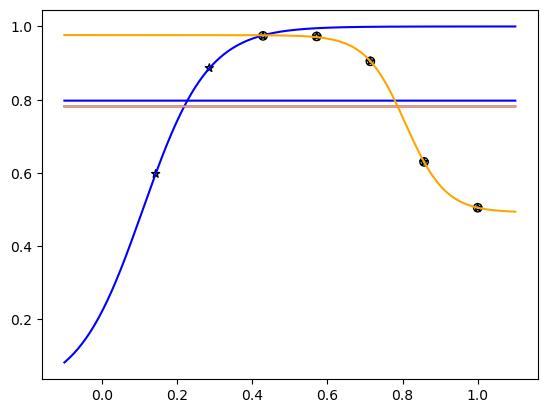

In [46]:
plot_inverse_sigmoid(df_full, CL, drug)

In [47]:
select_group_rows = lambda df, CL, drug: df[(df['CL'] == CL) & (df['DRUG_ID_lib'] == drug)]
select_rows = lambda df, CL, drug: df[(df['CL'] == CL) & (df['drug'] == drug)]
def plot_curve_CD_pair(df, CL, drug, norm=True):
    selected_final_df = select_rows(df, CL, drug)
    unique_maxc = selected_final_df['conc'].unique()
    single_color = len(unique_maxc) == 1
    if single_color:
        print(f'unique maxc values: {unique_maxc[0]}')
        print(f'number of experiments: {len(selected_final_df)}')
    else:
        print(f'number of unique maxc values: {len(unique_maxc)}')
        for maxc in unique_maxc:
            print(f'maxc value: {maxc} with {len(selected_final_df[selected_final_df["conc"] == maxc])} experiments')
    if norm:
        x_cols = [f'x_{i}' for i in range(7)]
        x_label = 'normalized concentration'
    else:
        x_cols = [f'conc_{i}' for i in range(7)]
        x_label = 'unnormalized concentration'
    y_final_cols = [f'y_{i}' for i in range(7)]
    if single_color:
        for x_col, y_final_cols in zip(x_cols, y_final_cols):
            # If only one unique maxc value, use a single color (e.g., 'blue')
            scatter = plt.scatter(selected_final_df[x_col], selected_final_df[y_final_cols], 
                                color = 'blue', alpha=0.5)
    else:
        for x_col, y_final_cols in zip(x_cols, y_final_cols):
            scatter = plt.scatter(selected_final_df[x_col], selected_final_df[y_final_cols], 
                                c=selected_final_df['conc'], cmap='viridis', alpha=0.5)
        plt.colorbar(scatter, label='maxc')

    plt.xlabel(x_label)
    plt.ylabel('Dose response')
    plt.title(f'Dose response screening for drug {drug} on cell line {CL}') 
    plt.show()

unique maxc values: 0.8
number of experiments: 1


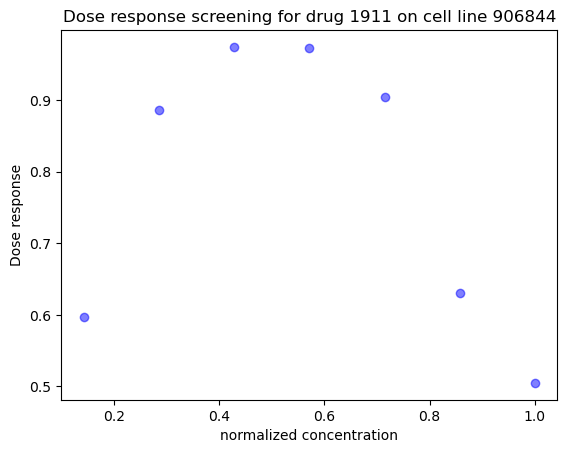

In [48]:
plot_curve_CD_pair(df_full, '906844', '1911', norm=True)

unique maxc values: 10
number of experiments: 77


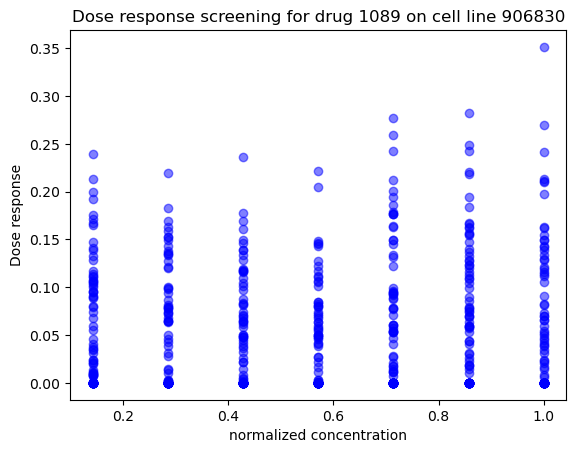

In [49]:
plot_curve_CD_pair(df_full, '906830', '1089', norm=True)

In [50]:
df_full[(df_full.last_min_y_index > df_full.first_max_y_index)].CL_drug_conc.value_counts().head(10)

CL_drug_conc
909776_1003_0.1    146
908134_1372_1       90
908134_1060_2.5     67
753608_1375_30      59
908134_1089_10      53
908134_1375_30      51
906830_1017_10      47
906830_1089_10      45
906830_1558_10      44
906830_1510_10      43
Name: count, dtype: int64

In [51]:
y_2_cols = [f'true_2_{i}' for i in range(7)]
y_4_cols = [f'true_4_{i}' for i in range(7)]
def last_occurrence_of_min_combine(row):
    # Reverse the row and find the first (in reverse order) occurrence of the min value
    return row[::-1].idxmin().split('_')[2]

def first_occurrence_of_max_combine(row):
    # Find the first occurrence of the max value
    return row.idxmax().split('_')[2]
combined_df['last_min_y_2_index'] = combined_df[y_2_cols].apply(last_occurrence_of_min_combine, axis=1)
combined_df['first_max_y_2_index'] = combined_df[y_2_cols].apply(first_occurrence_of_max_combine, axis=1)
combined_df['last_min_y_4_index'] = combined_df[y_4_cols].apply(last_occurrence_of_min_combine, axis=1)
combined_df['first_max_y_4_index'] = combined_df[y_4_cols].apply(first_occurrence_of_max_combine, axis=1)

In [52]:
condition_2_para = combined_df['last_min_y_2_index'] > combined_df['first_max_y_2_index']
condition_4_para = combined_df['last_min_y_4_index'] > combined_df['first_max_y_4_index']
subdf = combined_df[condition_2_para & condition_4_para]
subdf = subdf[subdf.last_min_y_2_index == '6'].sort_values('diff_2')
subdf[subdf.IC50_2_para < 1.5].sort_values('IC50_2_para', ascending=False).head(10)[['CL_drug_conc'] + y_2_cols]

,CL_drug_conc,true_2_0,true_2_1,true_2_2,true_2_3,true_2_4,true_2_5,true_2_6
47258,907323_1926_10,0.034422,0.046419,0.000000,0.204956,0.451373,0.531282,0.000000
22044,688031_1010_2,0.000000,0.000000,0.000000,0.090740,0.023030,0.601347,0.000000
23309,724825_1010_2,0.000000,0.000000,0.000000,0.000000,0.570949,0.458377,0.000000
37011,906818_1926_10,0.081902,0.024194,0.002197,0.059934,0.356727,0.615019,0.002197
44168,907271_1401_10,0.000000,0.000000,0.000000,0.000000,0.025904,0.335672,0.000000
3536,1240185_1926_10,0.049992,0.100909,0.191170,0.313826,0.566910,0.663199,0.000000
24594,724866_1926_10,0.017070,0.073144,0.196436,0.446029,0.626364,0.682413,0.000000
63313,910706_1941_10,0.962331,0.952779,0.970507,0.964731,0.975483,0.959955,0.948003
36946,906818_1373_10,0.486981,0.543906,0.527653,0.633363,0.641475,0.584578,0.481563
29022,753618_1190_10,0.865337,0.931195,0.909440,0.877928,0.840154,0.821234,0.777131


### There are cases with one outlier affect the curve

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1926 on cell line 724866 with max concentration 10 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

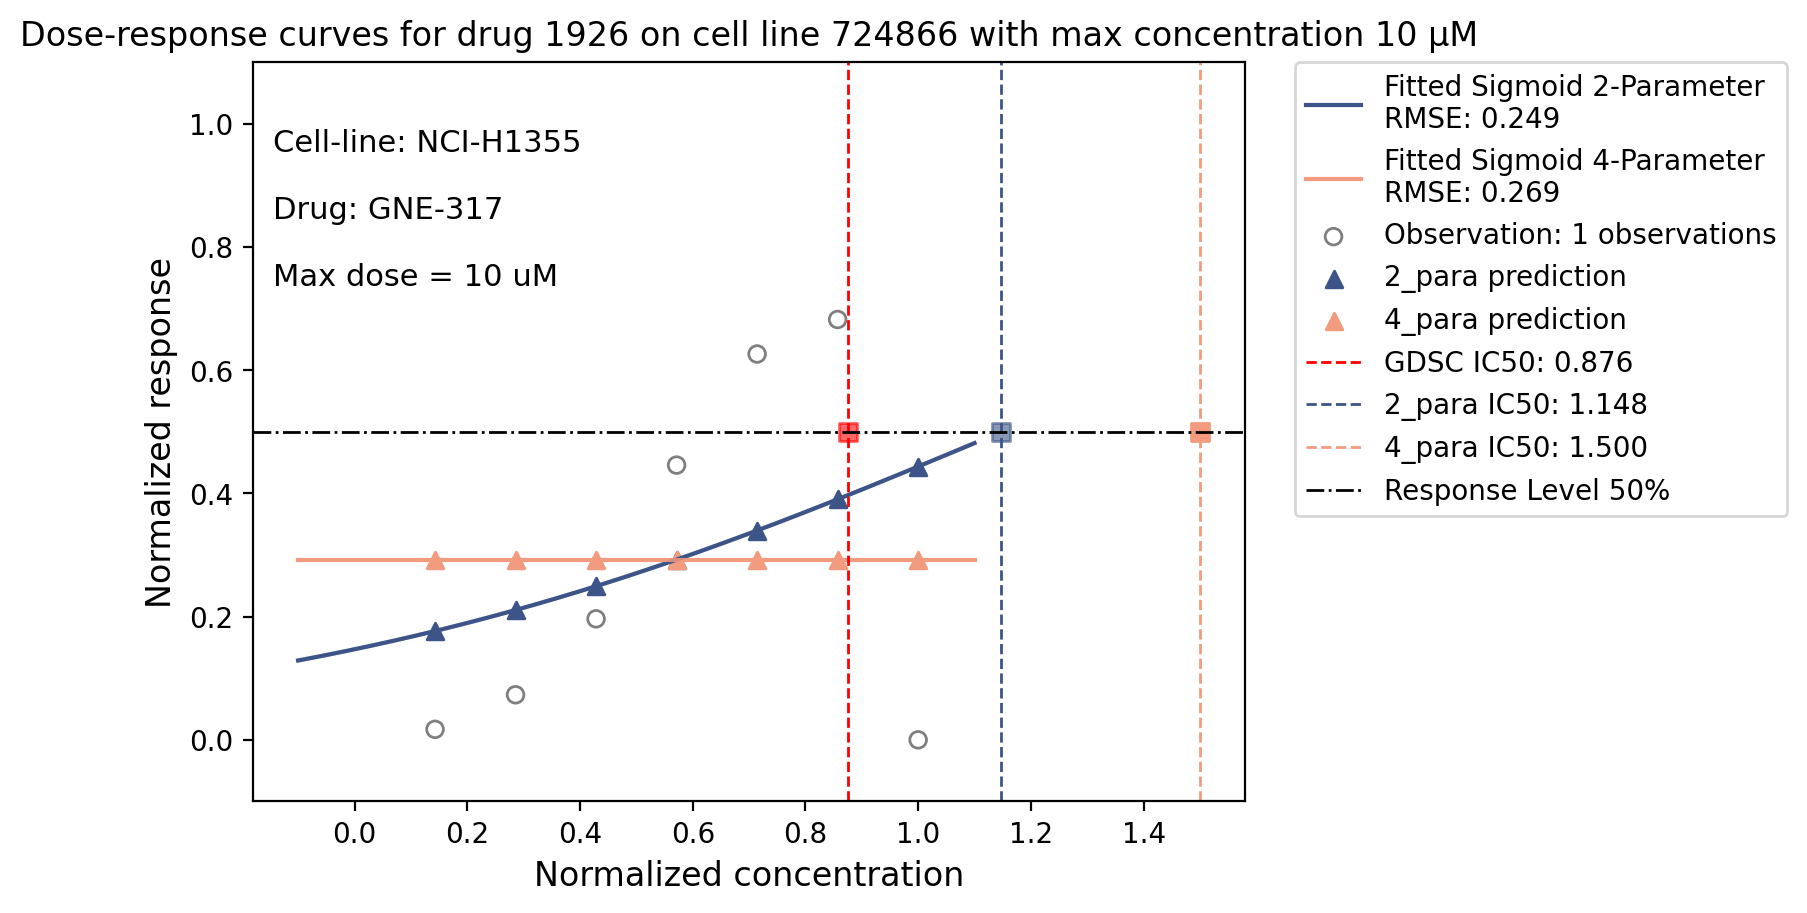

In [53]:
plot_all_observation_curves(df=df_full, CL='724866', drug='1926', plot_all_obs=True, show_nn_group=False, show_IC50='Best')

/tmp/ipykernel_3760868/3963090468.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (L + np.exp(-k * (c - c_0))) + d
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


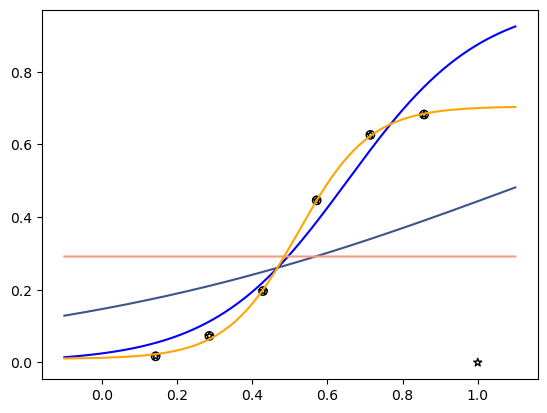

In [54]:
CL='724866'
drug='1926'
subrow = select_rows(df_full, CL, drug).sort_values('rmse_4_para').iloc[0]
# start = int(subrow.last_min_y_index)
# end = int(subrow.first_max_y_index) + 1
start = 0
end = 6
x_filter = subrow[x_cols].values[start:end]
y_filter = subrow[y_cols].values[start:end]
# x_filter = subrow[x_cols].values[end - 1:start + 1]
# y_filter = subrow[y_cols].values[end -1 :start + 1]
# x_opt = subrow[x_cols].values[0:end]
# y_opt = subrow[y_cols].values[0:end]
x = subrow[x_cols].values
y = subrow[y_cols].values
popt_2para, _ = curve_fit(sigmoid_2para, x, y, maxfev=10000)
popt_2para_filter, _ = curve_fit(sigmoid_2para, x_filter, y_filter, maxfev=10000)
# popt_2para_opt,_ = curve_fit(sigmoid_2para, x_opt, y_opt, maxfev=10000)
popt_4para, _ = curve_fit(sigmoid_4para, x, y, maxfev=10000)
popt_4para_filter, _ = curve_fit(sigmoid_4para, x_filter, y_filter, maxfev=10000)
# popt_4para_opt,_ = curve_fit(sigmoid_4para, x_opt, y_opt, maxfev=10000)
x_dense = np.linspace(-0.1, 1.1, 100000)
y_dense_2para = sigmoid_2para(x_dense, *popt_2para)
y_dense_2para_filter = sigmoid_2para(x_dense, *popt_2para_filter)
# y_dense_2para_opt = sigmoid_2para(x_dense, *popt_2para_opt)
y_dense_4para = sigmoid_4para(x_dense, *popt_4para)
y_dense_4para_filter = sigmoid_4para(x_dense, *popt_4para_filter)
# y_dense_4para_opt = sigmoid_4para(x_dense, *popt_4para_opt)
## Plot
# fig, ax = plt.subplots(dpi=200)
plt.plot(x_dense, y_dense_2para, label=f'Fitted Sigmoid 2-Parameter', color = '#3C5488FF')
plt.plot(x_dense, y_dense_2para_filter, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
# plt.plot(x_dense, y_dense_2para_opt, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
plt.plot(x_dense, y_dense_4para, label=f'Fitted Sigmoid 4-Parameter', color='#F39B7FFF')
plt.plot(x_dense, y_dense_4para_filter, color='orange')
# plt.plot(x_dense, y_dense_4para_opt, color='orange')
plt.scatter(x_filter, y_filter, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Filttered Observation')
plt.scatter(subrow[x_cols].values, subrow[y_cols].values, color='red', marker='*', facecolors='none', edgecolors='black', label = 'Filttered Observation')

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1926 on cell line 907323 with max concentration 10 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

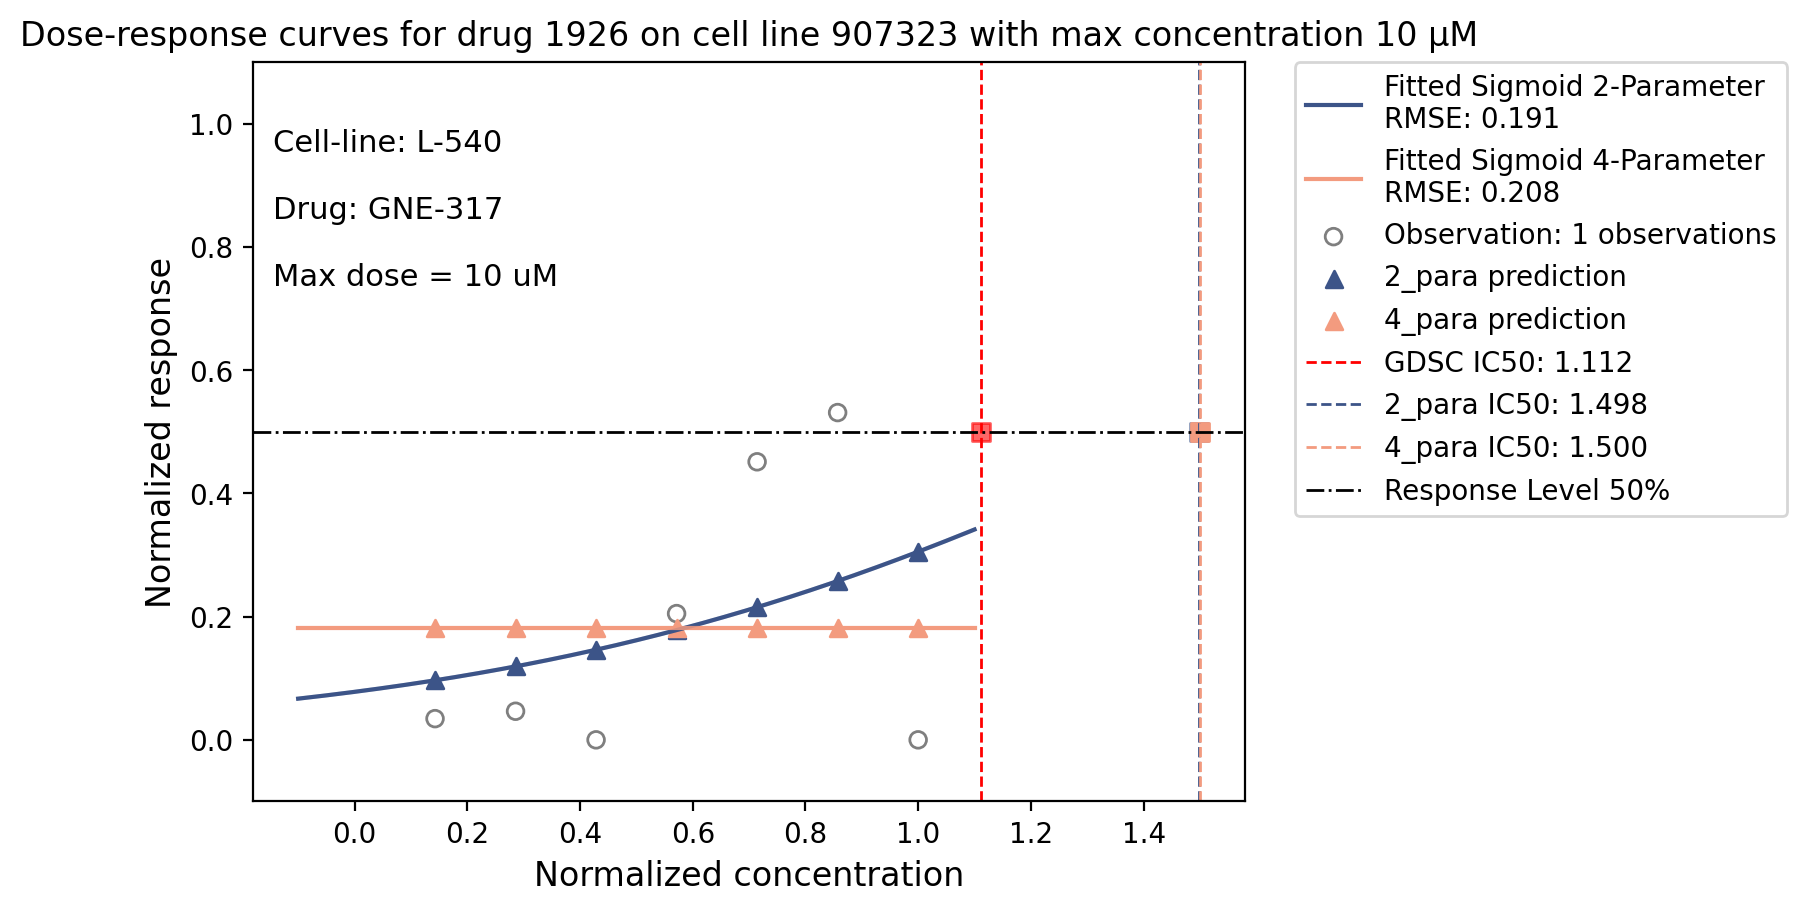

In [55]:

plot_all_observation_curves(df=df_full, CL='907323', drug='1926', plot_all_obs=True, show_nn_group=False, show_IC50='Best')

/tmp/ipykernel_3760868/3963090468.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (L + np.exp(-k * (c - c_0))) + d
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


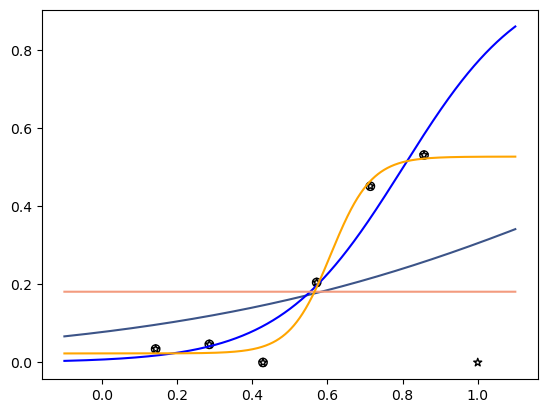

In [56]:
CL='907323'
drug='1926'
subrow = select_rows(df_full, CL, drug).sort_values('rmse_4_para').iloc[0]
# start = int(subrow.last_min_y_index)
# end = int(subrow.first_max_y_index) + 1
start = 0
end = 6
x_filter = subrow[x_cols].values[start:end]
y_filter = subrow[y_cols].values[start:end]
# x_filter = subrow[x_cols].values[end - 1:start + 1]
# y_filter = subrow[y_cols].values[end -1 :start + 1]
# x_opt = subrow[x_cols].values[0:end]
# y_opt = subrow[y_cols].values[0:end]
x = subrow[x_cols].values
y = subrow[y_cols].values
popt_2para, _ = curve_fit(sigmoid_2para, x, y, maxfev=10000)
popt_2para_filter, _ = curve_fit(sigmoid_2para, x_filter, y_filter, maxfev=10000)
# popt_2para_opt,_ = curve_fit(sigmoid_2para, x_opt, y_opt, maxfev=10000)
popt_4para, _ = curve_fit(sigmoid_4para, x, y, maxfev=10000)
popt_4para_filter, _ = curve_fit(sigmoid_4para, x_filter, y_filter, maxfev=10000)
# popt_4para_opt,_ = curve_fit(sigmoid_4para, x_opt, y_opt, maxfev=10000)
x_dense = np.linspace(-0.1, 1.1, 100000)
y_dense_2para = sigmoid_2para(x_dense, *popt_2para)
y_dense_2para_filter = sigmoid_2para(x_dense, *popt_2para_filter)
# y_dense_2para_opt = sigmoid_2para(x_dense, *popt_2para_opt)
y_dense_4para = sigmoid_4para(x_dense, *popt_4para)
y_dense_4para_filter = sigmoid_4para(x_dense, *popt_4para_filter)
# y_dense_4para_opt = sigmoid_4para(x_dense, *popt_4para_opt)
## Plot
# fig, ax = plt.subplots(dpi=200)
plt.plot(x_dense, y_dense_2para, label=f'Fitted Sigmoid 2-Parameter', color = '#3C5488FF')
plt.plot(x_dense, y_dense_2para_filter, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
# plt.plot(x_dense, y_dense_2para_opt, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
plt.plot(x_dense, y_dense_4para, label=f'Fitted Sigmoid 4-Parameter', color='#F39B7FFF')
plt.plot(x_dense, y_dense_4para_filter, color='orange')
# plt.plot(x_dense, y_dense_4para_opt, color='orange')
plt.scatter(x_filter, y_filter, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Filttered Observation')
plt.scatter(subrow[x_cols].values, subrow[y_cols].values, color='red', marker='*', facecolors='none', edgecolors='black', label = 'Filttered Observation')

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1926 on cell line 906818 with max concentration 10 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

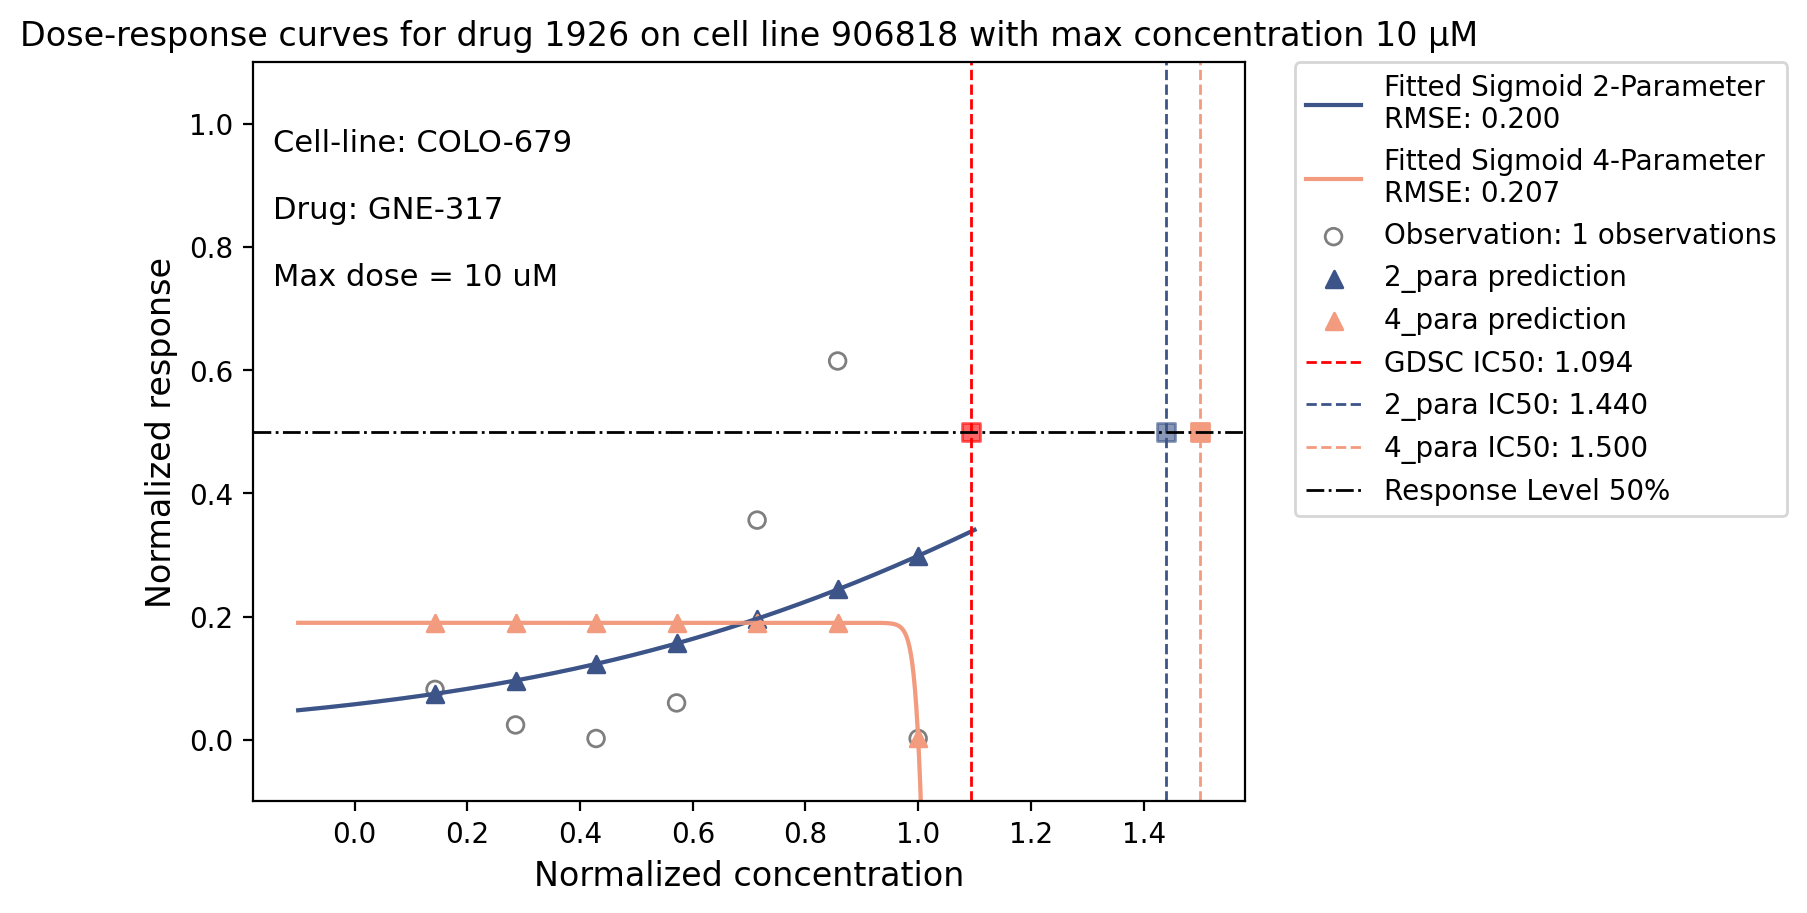

In [57]:
plot_all_observation_curves(df=df_full, CL='906818', drug='1926', plot_all_obs=True, show_nn_group=False, show_IC50='Best')

/tmp/ipykernel_3760868/3963090468.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (L + np.exp(-k * (c - c_0))) + d


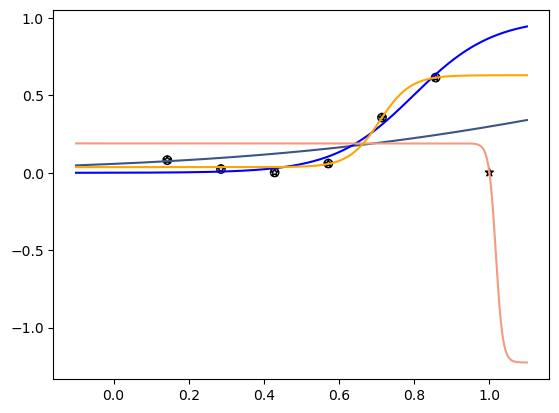

In [58]:
CL='906818'
drug='1926'
subrow = select_rows(df_full, CL, drug).sort_values('rmse_4_para').iloc[0]
# start = int(subrow.last_min_y_index)
# end = int(subrow.first_max_y_index) + 1
start = 0
end = 6
x_filter = subrow[x_cols].values[start:end]
y_filter = subrow[y_cols].values[start:end]
# x_filter = subrow[x_cols].values[end - 1:start + 1]
# y_filter = subrow[y_cols].values[end -1 :start + 1]
# x_opt = subrow[x_cols].values[0:end]
# y_opt = subrow[y_cols].values[0:end]
x = subrow[x_cols].values
y = subrow[y_cols].values
popt_2para, _ = curve_fit(sigmoid_2para, x, y, maxfev=10000)
popt_2para_filter, _ = curve_fit(sigmoid_2para, x_filter, y_filter, maxfev=10000)
# popt_2para_opt,_ = curve_fit(sigmoid_2para, x_opt, y_opt, maxfev=10000)
popt_4para, _ = curve_fit(sigmoid_4para, x, y, maxfev=10000)
popt_4para_filter, _ = curve_fit(sigmoid_4para, x_filter, y_filter, maxfev=10000)
# popt_4para_opt,_ = curve_fit(sigmoid_4para, x_opt, y_opt, maxfev=10000)
x_dense = np.linspace(-0.1, 1.1, 100000)
y_dense_2para = sigmoid_2para(x_dense, *popt_2para)
y_dense_2para_filter = sigmoid_2para(x_dense, *popt_2para_filter)
# y_dense_2para_opt = sigmoid_2para(x_dense, *popt_2para_opt)
y_dense_4para = sigmoid_4para(x_dense, *popt_4para)
y_dense_4para_filter = sigmoid_4para(x_dense, *popt_4para_filter)
# y_dense_4para_opt = sigmoid_4para(x_dense, *popt_4para_opt)
## Plot
# fig, ax = plt.subplots(dpi=200)
plt.plot(x_dense, y_dense_2para, label=f'Fitted Sigmoid 2-Parameter', color = '#3C5488FF')
plt.plot(x_dense, y_dense_2para_filter, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
# plt.plot(x_dense, y_dense_2para_opt, label=f'Fitted Sigmoid 2-Parameter', color = 'blue')
plt.plot(x_dense, y_dense_4para, label=f'Fitted Sigmoid 4-Parameter', color='#F39B7FFF')
plt.plot(x_dense, y_dense_4para_filter, color='orange')
# plt.plot(x_dense, y_dense_4para_opt, color='orange')
plt.scatter(x_filter, y_filter, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Filttered Observation')
plt.scatter(subrow[x_cols].values, subrow[y_cols].values, color='red', marker='*', facecolors='none', edgecolors='black', label = 'Filttered Observation')

### There are non-response curves

/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))


/tmp/ipykernel_3760868/3963090468.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp((x - p) / -s))


(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1089 on cell line 906830 with max concentration 10 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

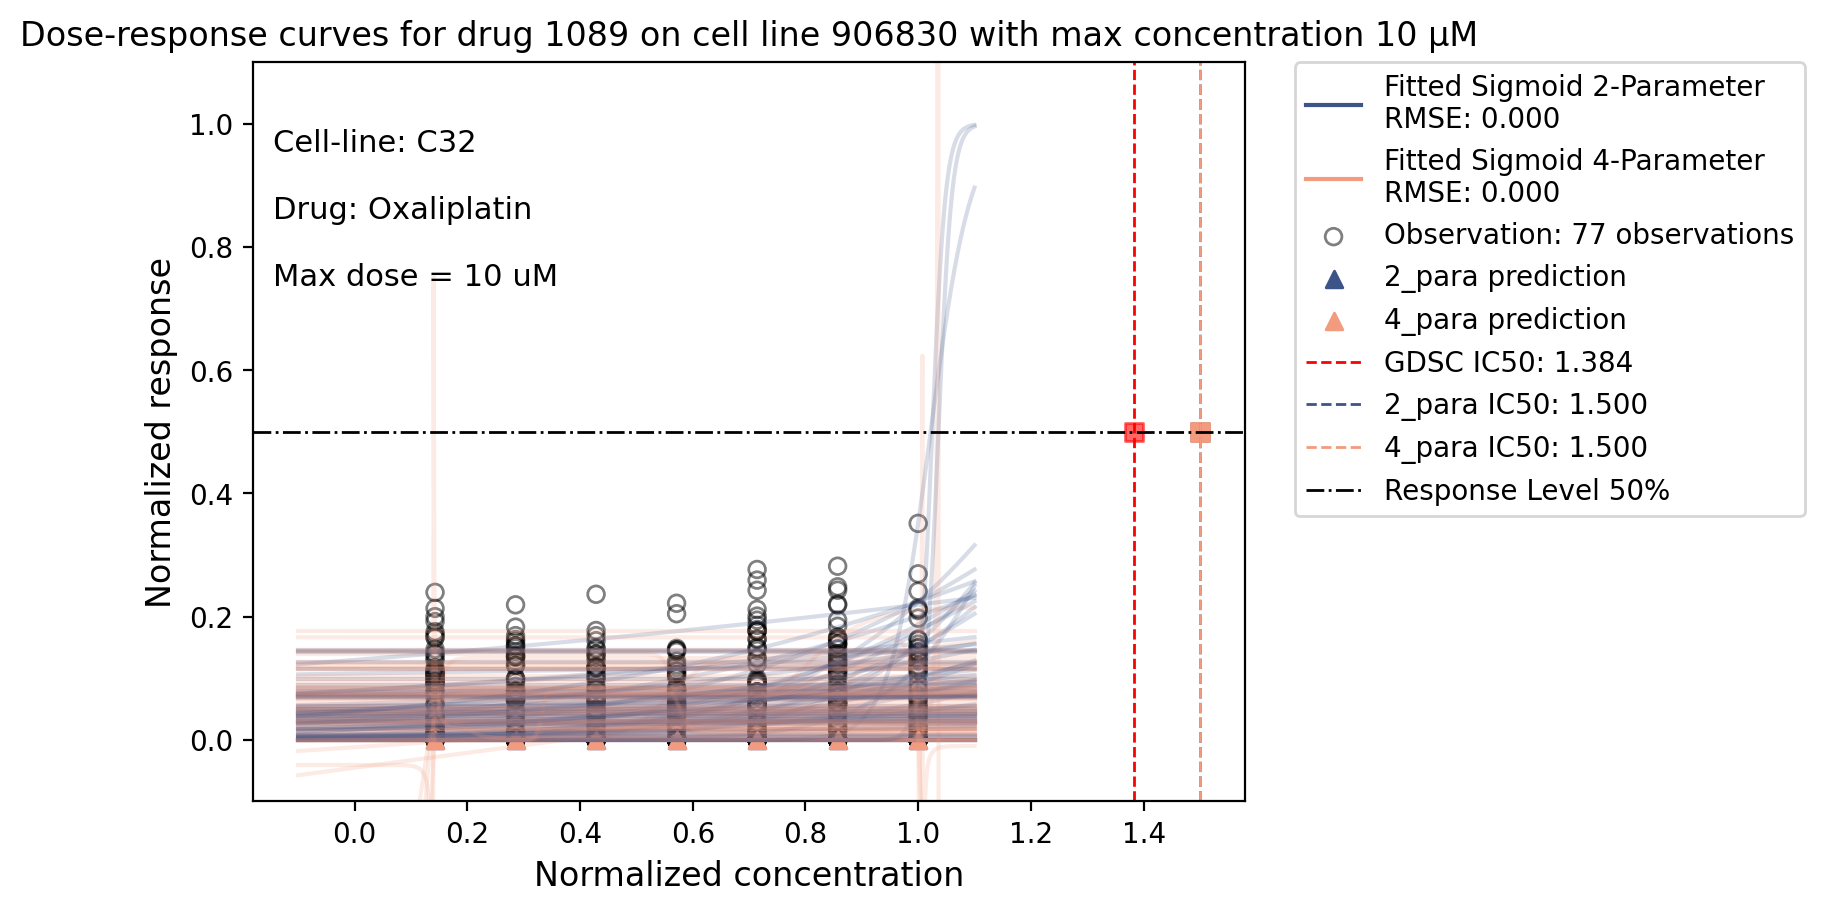

In [59]:
plot_all_observation_curves(df=df_full, CL='906830', drug='1089', plot_all_obs=True, show_nn_group=False, show_IC50='Best')

## Detect outliers

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 1463 on cell line 1659823 with max concentration 10 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

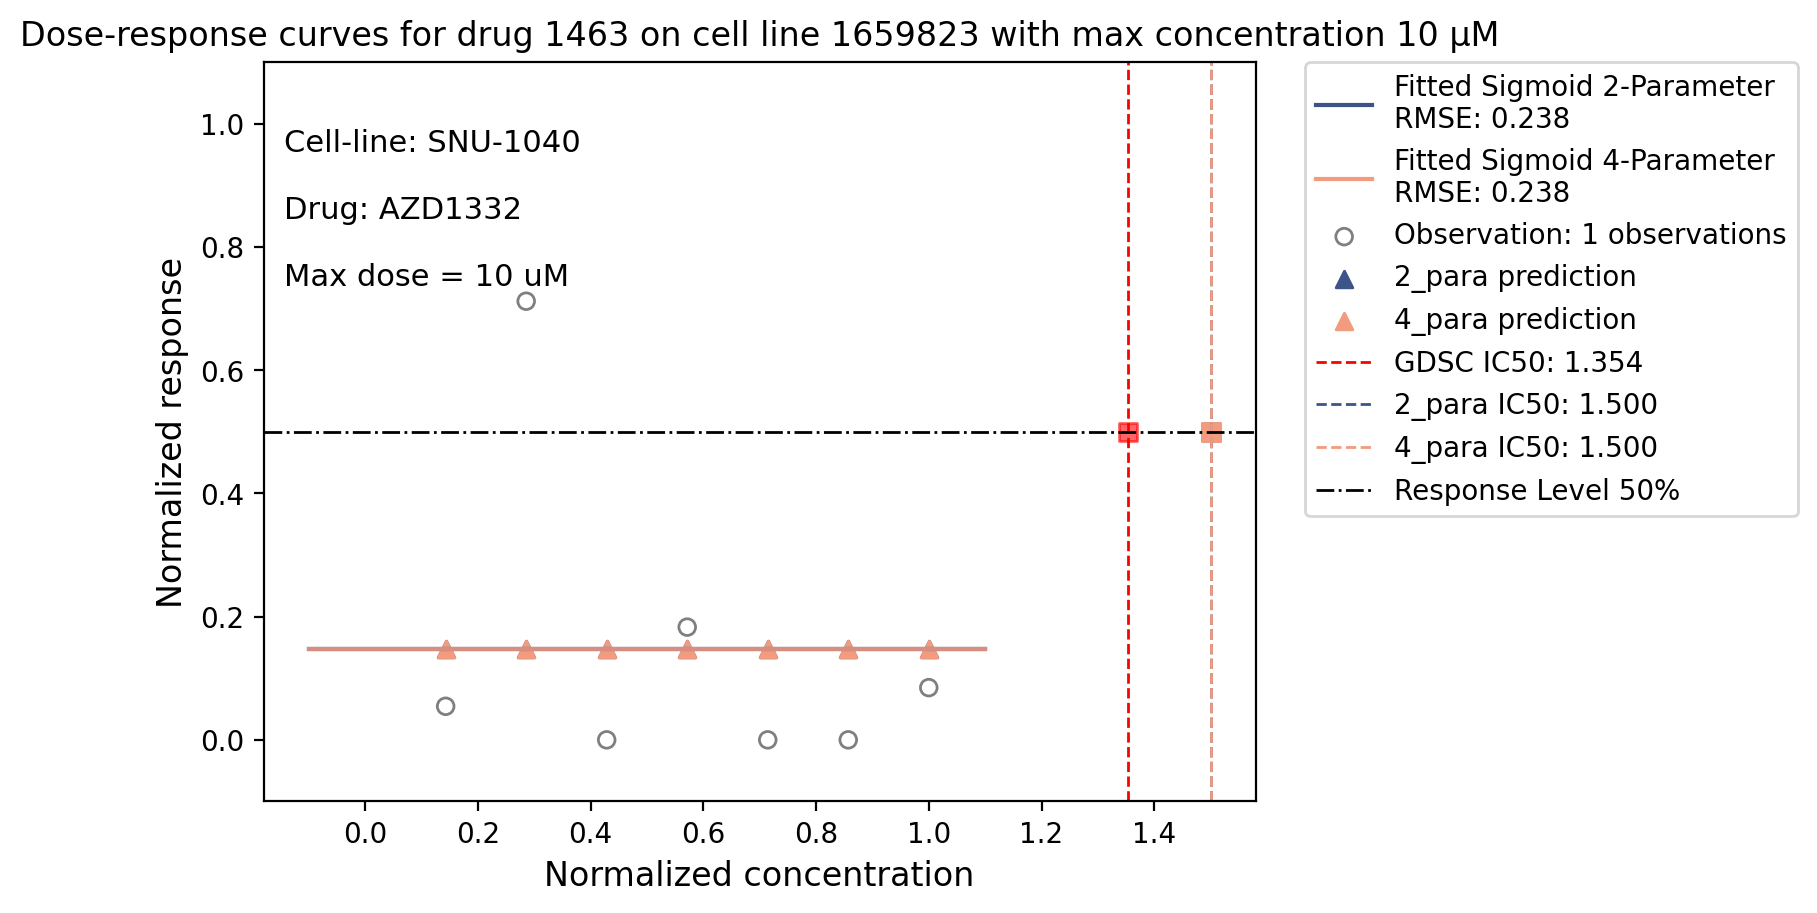

In [60]:
plot_all_observation_curves(df=df_full, CL='1659823', drug='1463', plot_all_obs=True, show_nn_group=False, show_IC50='Best')